# Getting Fairness Correction Metrics

#### Load pandas and numpy

In [1]:
import pandas as pd
import numpy as np

#### Split data into train/test sets

In [2]:
def ttSplit(df, ts=0.10):
    """Train / Test split dataframe df with test proportion ts. Also get
    an additional train /test set with protected attribute reversed for counterfactual analysis."""
    
    from sklearn.model_selection import train_test_split

    train, test = train_test_split(df, test_size=ts)

    X_test = test.drop([label], axis=1).values
    y_test = test[label].values

    rtest = test.copy()
    ftest = test.copy()
    utest = test.copy()
    
    rtest[pa] = [0 if s == 1 else 1 for s in test[pa]]
    ftest[pa] = 1
    utest[pa] = 0
    
    rX_test = rtest.drop([label], axis=1).values
    ry_test = rtest[label].values
    fX_test = ftest.drop([label], axis=1).values
    fy_test = ftest[label].values
    uX_test = utest.drop([label], axis=1).values
    uy_test = utest[label].values
    
    ttdict = {
        'train': train,
        'test': test,
        'rtest': rtest,
        'ftest': ftest,
        'utest': utest,
        'X_test': X_test,
        'y_test': y_test,
        'rX_test': rX_test,
        'ry_test': ry_test,
        'fX_test': fX_test,
        'fy_test': fy_test,
        'uX_test': uX_test,
        'uy_test': uy_test,
    }

    return ttdict

#### Find favoured group

In [3]:
def findFav(ttdict, pa, label):
    train = ttdict['train']

    pos_rates = [train[(train[pa] == u) & (train[label] == 1)].shape[0] / train[train[pa] == u].shape[0]
                 for u in train[pa].unique()]
    max_value = max(pos_rates)
    max_index = pos_rates.index(max_value)

    # Favoured group
    fav = train[pa].unique()[max_index]
    return fav

### Fairness Correction Functions

In [4]:
def fairCorrectUnder(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through
    subsampling the favoured positive and unfavoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function
    import math
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

#     # coefficients for fitting quad function
#     a = ((fav_pr + unfav_pr) / 2) - pr
#     b = (fav_pr - unfav_pr) / 2
#     c = pr
    
#     # corrected ratios (quadratic)
#     corr_fpr = (a * (d ** 2)) + (b * d) + c
#     corr_upr = (a * (d ** 2)) - (b * d) + c
    
    #coefficients for fitting line
    m = (fav_pr - unfav_pr) / 2
    b2 = (fav_pr + unfav_pr) / 2
    
    # corrected ratios (linear)
    corr_fpr = m * d + b2
    corr_upr = -m * d + b2
    
    # correcting constants
    fav_k = corr_fpr / (1 - corr_fpr)
    unfav_k = (1 - corr_upr) / corr_upr
    
    # sample sizes for fav_pos and unfav_neg
    fav_pos_size = math.floor(fav_neg.shape[0] * fav_k)
    unfav_neg_size = math.floor(unfav_pos.shape[0] * unfav_k)
    
    # samples from fav_pos and unfav_neg to correct proportions
    corr_fav_pos = fav_pos.sample(fav_pos_size)
    corr_unfav_neg = unfav_neg.sample(unfav_neg_size)
    
    # concatenate df's
    corr_dfs = [corr_fav_pos, fav_neg, unfav_pos, corr_unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [5]:
def fairCorrectOver(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through
    oversampling the unfavoured positive and favoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function
    import math
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

#     # coefficients for fitting quad function
#     a = ((fav_pr + unfav_pr) / 2) - pr
#     b = (fav_pr - unfav_pr) / 2
#     c = pr

#     # corrected ratios
#     corr_fpr = (a * (d ** 2)) + (b * d) + c
#     corr_upr = (a * (d ** 2)) - (b * d) + c
    
    #coefficients for fitting line
    m = (fav_pr - unfav_pr) / 2
    b2 = (fav_pr + unfav_pr) / 2
    
    # corrected ratios (linear)
    corr_fpr = m * d + b2
    corr_upr = -m * d + b2
    
    # correcting constants
    fav_k = (1 - corr_fpr) / corr_fpr
    unfav_k = corr_upr / (1 - corr_upr)
       
    # sample sizes for unfav_pos and fav_neg
    unfav_pos_size = math.floor(unfav_neg.shape[0] * unfav_k)
    fav_neg_size = math.floor(fav_pos.shape[0] * fav_k)
    
    # samples from fav_pos and unfav_neg to correct proportions
    corr_unfav_pos = unfav_pos.sample(unfav_pos_size, replace=True)
    corr_fav_neg = fav_neg.sample(fav_neg_size, replace=True)
    
    # concatenate df's
    corr_dfs = [corr_unfav_pos, fav_pos, unfav_neg, corr_fav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [6]:
def fairCorrectSMOTE(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through 
    oversampling the unfavoured positive and favoured negative classes. Parameter d should be
    a number between -1 and 1 for this to work properly."""
    
    # import math for floor function, SMOTE for oversampling
    import math
    from imblearn.over_sampling import SMOTE
    
    # Put label last for easier manipulation
    df = df[[c for c in df if c not in ['label']] + ['label']]
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = df[(df[pa] == fav) & (df.label == 1)]
    fav_neg = df[(df[pa] == fav) & (df.label == 0)]
    unfav_pos = df[(df[pa] != fav) & (df.label == 1)]
    unfav_neg = df[(df[pa] != fav) & (df.label == 0)]
    
    # get favoured and unfavoured number of rows
    fav_size = fav_pos.shape[0] + fav_neg.shape[0]
    unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

    # get positive ratios for favoured and unfavoured
    fav_pr = fav_pos.shape[0] / fav_size
    unfav_pr = unfav_pos.shape[0] / unfav_size
    pr = df[df[label] == 1].shape[0] / df.shape[0]

#     # coefficients for fitting quad function
#     a = ((fav_pr + unfav_pr) / 2) - pr
#     b = (fav_pr - unfav_pr) / 2
#     c = pr

#     # corrected ratios
#     corr_fpr = (a * (d ** 2)) + (b * d) + c
#     corr_upr = (a * (d ** 2)) - (b * d) + c
    
    #coefficients for fitting line
    m = (fav_pr - unfav_pr) / 2
    b2 = (fav_pr + unfav_pr) / 2
    
    # corrected ratios (linear)
    corr_fpr = m * d + b2
    corr_upr = -m * d + b2
    
    # correcting constants
    fav_k = (1 - corr_fpr) / corr_fpr
    unfav_k = corr_upr / (1 - corr_upr)
    
    # SMOTE oversample UP & FN to correct constant
    
    sm = SMOTE()
    auxfav = fav_pos.sample(math.floor(fav_pos.shape[0] * fav_k),
                               replace=True)
    auxunfav = unfav_neg.sample(math.floor(unfav_neg.shape[0] * unfav_k),
                                   replace=True)
    
    dff_pre = pd.concat([auxfav, fav_neg])
    dfu_pre = pd.concat([unfav_pos, auxunfav])
    
    # Split in X & y for SMOTE to work
    Xf_pre = dff_pre.drop(['label'], axis=1).values
    Xu_pre = dfu_pre.drop(['label'], axis=1).values
    yf_pre = dff_pre.label.values
    yu_pre = dfu_pre.label.values

    # Apply SMOTE
    X_smf, y_smf = sm.fit_sample(Xf_pre, yf_pre)
    X_smu, y_smu = sm.fit_sample(Xu_pre, yu_pre)
    
    # Put back together into dataframes
    y_smf = y_smf.reshape((y_smf.shape[0], 1))
    X_smf = np.append(X_smf, y_smf, axis=1)
    y_smu = y_smu.reshape((y_smu.shape[0], 1))
    X_smu = np.append(X_smu, y_smu, axis=1)
    smfDF = pd.DataFrame(X_smf, columns=df.columns.tolist())
    smuDF = pd.DataFrame(X_smu, columns=df.columns.tolist())
    
    # concatenate df's
    corr_dfs = [smfDF[smfDF.label == 0], smuDF[smuDF.label == 1], fav_pos, unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

In [7]:
def fairCorrectPSP(df, pa, fav, d=1):
    """Correct the proportion of positive cases for favoured and unfavoured subgroups through
    Preferential Sampling, oversampling the unfavoured positive and favoured negative
    and undersampling the favoured positive and unfavoured negative classes.
    Parameter d should be a number between -1 and 1 for this to work properly."""
    from sklearn.naive_bayes import GaussianNB as nb
    import math
    
    df2 = df.copy()
    
    # Train NB model and get prediction confidence
    Xnb = df.drop([label], axis=1).values
    ynb = df[label].values
    
    model = nb()
    model.fit(Xnb, ynb)
    logProbs = model.predict_log_proba(Xnb)
    df2['pPos'] = [logProbs[i][1] for i in range(len(logProbs))]
    
    # subset favoured positive, favoured negative, unfavoured positive, unfavoured negative
    fav_pos = (df2[(df2[pa] == fav) & (df2[label] == 1)]
               .sort_values('pPos', ascending=True))
    fav_neg = (df2[(df2[pa] == fav) & (df2[label] == 0)]
               .sort_values('pPos', ascending=False))
    unfav_pos = (df2[(df2[pa] != fav) & (df2[label] == 1)]
                 .sort_values('pPos', ascending=True))
    unfav_neg = (df2[(df2[pa] != fav) & (df2[label] == 0)]
                 .sort_values('pPos', ascending=False))
    
    # drop aux columns
    fav_pos = fav_pos.drop(['pPos'], axis=1)
    fav_neg = fav_neg.drop(['pPos'], axis=1)
    unfav_pos = unfav_pos.drop(['pPos'], axis=1)
    unfav_neg = unfav_neg.drop(['pPos'], axis=1)
    
    if d < 1:

        # get favoured and unfavoured number of rows
        fav_size = fav_pos.shape[0] + fav_neg.shape[0]
        unfav_size = unfav_pos.shape[0] + unfav_neg.shape[0]

        # get positive ratios for favoured and unfavoured
        fav_pr = fav_pos.shape[0] / fav_size
        unfav_pr = unfav_pos.shape[0] / unfav_size
        pr = df[df[label] == 1].shape[0] / df.shape[0]

#         # coefficients for fitting quad function
#         a = ((fav_pr + unfav_pr) / 2) - pr
#         b = (fav_pr - unfav_pr) / 2
#         c = pr

#         # corrected ratios
#         corr_fpr = (a * (d ** 2)) + (b * d) + c
#         corr_upr = (a * (d ** 2)) - (b * d) + c
        
        #coefficients for fitting line
        m = (fav_pr - unfav_pr) / 2
        b2 = (fav_pr + unfav_pr) / 2

        # corrected ratios (linear)
        corr_fpr = m * d + b2
        corr_upr = -m * d + b2

        # number of elements to remove or add
        fav_move = math.floor((fav_pr - corr_fpr) * fav_size)
        unfav_move = math.floor((corr_upr - unfav_pr) * unfav_size)

        # elements to add
        ext_fn = pd.concat([fav_neg] * math.ceil(fav_move / fav_neg.shape[0]), ignore_index=True)
        ext_up = pd.concat([unfav_pos] * math.ceil(unfav_move / unfav_pos.shape[0]), ignore_index=True)
    
        # remove from fp and un
        fav_pos = fav_pos.tail(fav_pos.shape[0] - fav_move)
        unfav_neg = unfav_neg.tail(unfav_neg.shape[0] - unfav_move)
    
        # add to fn and up
        fav_neg = pd.concat([fav_neg, ext_fn.head(fav_move)], ignore_index=True) 
        unfav_pos = pd.concat([unfav_pos, ext_up.head(unfav_move)], ignore_index=True)
    
    # concatenate df's
    corr_dfs = [fav_pos, fav_neg, unfav_pos, unfav_neg]
    corr_df = pd.concat(corr_dfs)
    
    return corr_df

#### Make array of corrected training sets for different values of *d*

In [8]:
def correctTrains(train, pa, fav, FCfun):
    corr_trains = []
    Xs = []
    ys = []

    for i in range(11):
        tdf = FCfun(train, pa, fav, d=1-(0.2*i))
        corr_trains.append(tdf)
    
    for i in range(11):
        X = corr_trains[i].drop([label], axis=1).values
        y = corr_trains[i][label].values
        Xs.append(X)
        ys.append(y)
    
    corrected = {
        'corr_trains': corr_trains,
        'Xs': Xs,
        'ys': ys,
    }
    
    return corrected

#### Get predictions for test set out of models learned from the different training sets

In [9]:
def makePreds(Xs, ys, X_test):
    from sklearn.linear_model import LogisticRegression

    models = []
    preds = []

    for i in range(11):
        model = LogisticRegression(solver='liblinear')
        model.fit(Xs[i], ys[i])
        models.append(model)
    
        p = model.predict(X_test)
        preds.append(p)
    
    outputs = {
        'models': models,
        'preds': preds,
    }
    
    return outputs

#### Get different models' coefficients

In [10]:
def getCoefs(train, models):
    # Modified for multipa (dropping pa)
    train2 = train.drop([label, pa], axis=1)

    dfc = pd.DataFrame(columns=train2.columns.values)
    for i in range(dfc.shape[1]):
        dfc[dfc.columns.values[i]] = [models[j].coef_[0][i] for j in range(11)]
    dfc['disparity'] = [(1 - 0.2*i) for i in range(11)]
    return dfc

#### Add predictions to test sets for analysis

In [11]:
def addPreds(test, preds):
    for i in range(11):
        test['pred' + str(i)] = preds[i]
    return test

### Main function, performs the whole process

In [12]:
def Workflow(df, n, pa, label, FCfun):
    Coefs = []
    Trains = []
    Tests = []
    rTests = []
    fTests = []
    uTests = []

    for i in range(n):
        ttdict = ttSplit(df, 0.10)
        train = ttdict['train']
        test = ttdict['test']
        rtest = ttdict['rtest']
        ftest = ttdict['ftest']
        utest = ttdict['utest']
        X_test = ttdict['X_test']
        rX_test = ttdict['rX_test']
        fX_test = ttdict['fX_test']
        uX_test = ttdict['uX_test']
        fav = findFav(ttdict, pa, label)
        
        corrected = correctTrains(train, pa, fav, FCfun)
        corr_trains = corrected['corr_trains']
        Xs = corrected['Xs']
        ys = corrected['ys']
        
        outputs = makePreds(Xs, ys, X_test)
        models = outputs['models']
        preds = outputs['preds']
        
        rOutputs = makePreds(Xs, ys, rX_test)
        rpreds = rOutputs['preds']
        
        fOutputs = makePreds(Xs, ys, fX_test)
        fpreds = fOutputs['preds']
        
        uOutputs = makePreds(Xs, ys, uX_test)
        upreds = uOutputs['preds']
        
        coefs = getCoefs(train, models)
        test = addPreds(test, preds)
        rtest = addPreds(rtest, rpreds)
        ftest = addPreds(ftest, fpreds)
        utest = addPreds(utest, upreds)
        
        Coefs.append(coefs)
        Trains.append(corr_trains)
        Tests.append(test)
        rTests.append(rtest)
        fTests.append(ftest)
        uTests.append(utest)
        
    Outs = {
        'Coefs': Coefs,
        'Trains': Trains,
        'Tests': Tests,
        'rTests': rTests,
        'fTests': fTests,
        'uTests': uTests,
        'fav': fav,
        'fun': FCfun.__name__,
    }
    
    return Outs

### Make experiments for all four correction methods

#### Dictionaries for file name, protected attribute and label for every dataset

In [13]:
Income = {
    'df': 'income_onehot.csv',
    'pa': 'sex',
    'label': 'label',
}

IncomePA = {
    'df': 'income_mod_onehot.csv',
    'pa': 'PA',
    'label': 'label',
}

COMPAS = {
    'df': 'compas_onehot.csv',
    'pa': 'race',
    'label': 'label',
}

German = {
    'df': 'german_onehot.csv',
    'pa': 'gender',
    'label': 'label',
}

DSets = {
    'Income': Income,
    'IncomePA': IncomePA,
    'COMPAS': COMPAS,
    'German': German,
}

#### Load data and assign df, pa and label variables based on dataset

In [14]:
# Set desired Dataset here, values can be: 'Income', 'COMPAS', 'German'
dset = 'Income'

url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'
savepath = '../Datasets/'

# Remotely Load Data
# df = pd.read_csv(url + DSets[dset]['df'], header=0)

# Locally Load Data
df = pd.read_csv(savepath + DSets[dset]['df'], header=0)

pa = DSets[dset]['pa']
label = DSets[dset]['label']

#### Make Experiments for selected dset

In [15]:
expNames = [
#     'expUnder',
#     'expOver',
#     'expSMOTE',
    'expPSP',
]

fcFunctions = [
#     fairCorrectUnder,
#     fairCorrectOver,
#     fairCorrectSMOTE,
    fairCorrectPSP,
]

combined = zip(expNames, fcFunctions)

experiments = {name: Workflow(df, 20, pa, label, func) for name, func in combined}

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

#### Save experiments to pickle file

In [74]:
import pickle
expFile = open('../Datasets/experiments_' + dset + '.obj', 'wb') 
pickle.dump(experiments, expFile)

### Get Metrics for experiment

#### Volatility Function

In [75]:
def getVolas(df, pa, fav):
    cols = {
        'real': df[label],
        'base': df['pred0'],
    }

    for i in range(10):
        cols['pred' + str(i + 1)] = df['pred' + str(i + 1)]

    vDF = pd.DataFrame(cols)
    
    for i in range(10):
        vDF['vola' + str(i + 1)] = [0 if (p == q and p == r) else
                                    1 if (p == r or  q == r) else
                                    2 if (p == q and p != r) else
                                    3 for (p, q, r) in zip(vDF.base,
                                                           vDF['pred' + str(i + 1)],
                                                           vDF.real)]
       
        vDF['change' + str(i + 1)] = [0 if (p == q) else
                                      1 if (p < q) else
                                      2 for (p, q) in zip(vDF.base, vDF['pred' + str(i + 1)])]
        
    vDF = vDF.drop(['real', 'base'], axis=1)

    for i in range(1, 11):
        vDF = vDF.drop(['pred' + str(i)], axis=1)
        
    test2 = df.reset_index()
    vdf2 = vDF.reset_index()
    testdf = pd.concat([test2,vdf2], axis=1)
    testdf = testdf.drop(['index'], axis=1)

    vola = [[np.nan], [np.nan], [np.nan]]
    uvola = [[np.nan], [np.nan], [np.nan]]
    fvola = [[np.nan], [np.nan], [np.nan]]

    for i in range(10):
        for j in range(3):
        
            if j in testdf['vola' + str(i + 1)].unique():
                vcn = testdf['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                vcn = 0
            vola[j].append(vcn)
        
            if j in testdf[testdf[pa] != fav]['vola' + str(i + 1)].unique():
                uvcn = testdf[testdf[pa] != fav]['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                uvcn = 0
            uvola[j].append(uvcn)
        
            if j in testdf[testdf[pa] == fav]['vola' + str(i + 1)].unique():
                fvcn = testdf[testdf[pa] == fav]['vola' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                fvcn = 0
            fvola[j].append(fvcn)
            
    change = [[np.nan], [np.nan], [np.nan]]
    uchange = [[np.nan], [np.nan], [np.nan]]
    fchange = [[np.nan], [np.nan], [np.nan]]

    # Get changes (0 is same, 1 is bad to good, 2 is good to bad)
    
    for i in range(10):
        for j in range(3):
        
            if j in testdf['change' + str(i + 1)].unique():
                cvcn = testdf['change' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                cvcn = 0
            change[j].append(cvcn)
        
            if j in testdf[testdf[pa] != fav]['change' + str(i + 1)].unique():
                ucvcn = testdf[testdf[pa] != fav]['change' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                ucvcn = 0
            uchange[j].append(ucvcn)
        
            if j in testdf[testdf[pa] == fav]['change' + str(i + 1)].unique():
                fcvcn = testdf[testdf[pa] == fav]['change' + str(i + 1)].value_counts(normalize=True, sort=False)[j]
            else:
                fcvcn = 0
            fchange[j].append(fcvcn)
    
    Volas = {
        'vola': vola,
        'uvola': uvola,
        'fvola': fvola,
        'change': change,
        'uchange': uchange,
        'fchange': fchange,
    }
    
    return Volas

### Main Metrics function

In [76]:
def getMetrics(exp):    
    from sklearn.metrics import accuracy_score
    
    Coefs = exp['Coefs']
    Tests = exp['Tests']
    rTests = exp['rTests']
    fTests = exp['fTests']
    uTests = exp['uTests']
    fav = exp['fav']
    sampstrat = exp['fun']
    Metrics = []

    for i in range(len(Tests)):
        test = Tests[i]
        rtest = rTests[i]
        ftest = fTests[i]
        utest = uTests[i]
        dvals = [round((1 - 0.2 * i), 1) for i in range(11)]
        accs = [accuracy_score(test.label, test['pred' + str(i)]) for i in range(11)]
        f_accs = [accuracy_score(test[test[pa] == 0].label, test[test[pa] == 0]['pred' + str(i)]) for i in range(11)]
        m_accs = [accuracy_score(test[test[pa] == 1].label, test[test[pa] == 1]['pred' + str(i)]) for i in range(11)]
        unfav_pos = [test[test[pa] != fav]['pred' + str(i)].value_counts(normalize=True)[1]
                     for i in range(11)]
        fav_pos = [test[test[pa] == fav]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        tot_pos = [test['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        fem_pos = [test[test['sex'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        male_pos = [test[test['sex'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        w_pos = [test[test['White'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        nw_pos = [test[test['White'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        us_pos = [test[test['United-States'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        nus_pos = [test[test['United-States'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        o35_pos = [test[test['age'] >= 35]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        no35_pos = [test[test['age'] < 35]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]

        metrics = pd.DataFrame({
            'disparity': dvals,
            'accuracy': accs,
            'fem_accu': f_accs,
            'male_accu': m_accs,
            'positive_rate': tot_pos,
            'unfav_positive_rate': unfav_pos,
            'fav_positive_rate': fav_pos,
            'fem_pos' : fem_pos,
            'male_pos': male_pos,
            'w_pos': w_pos,
            'nw_pos': nw_pos,
            'us_pos': us_pos,
            'nus_pos': nus_pos,
            'o35_pos': o35_pos,
            'no35_pos': no35_pos,
        })

        # Equality of Opportunity Metrics
        metrics['uo'] = [len(test[(test[pa] != fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] != fav) & (test.label == 1)]) for i in range(11)]
        metrics['fo'] = [len(test[(test[pa] == fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] == fav) & (test.label == 1)]) for i in range(11)]
        metrics['eo'] = [len(test[(test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[test.label == 1]) for i in range(11)]
        metrics['eo_rate'] = metrics.uo / metrics.fo

        # Counterfactual Metrics
        raccs = [accuracy_score(rtest[label], rtest['pred' + str(i)]) for i in range(11)]
        rupos = [rtest[rtest[pa] == fav]['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        rfpos = [rtest[rtest[pa] != fav]['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        rtpos = [rtest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        fpos = [ftest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]
        upos = [utest['pred' + str(i)].value_counts(normalize=True)[1]
                for i in range(11)]

        rmetrics = pd.DataFrame({
            'r_accuracy': raccs,
            'r_positive_rate': rtpos,
            'r_unfav_positive_rate': rupos,
            'r_fav_positive_rate': rfpos,
            'fav_pos_rate': fpos,
            'unfav_pos_rate': upos,
        })

        metrics = pd.concat([metrics, rmetrics], axis=1)
        metrics['cfact'] = metrics.positive_rate / rmetrics.r_positive_rate
        metrics['ucfact'] = metrics.unfav_positive_rate / rmetrics.r_unfav_positive_rate
        metrics['fcfact'] = metrics.fav_positive_rate / rmetrics.r_fav_positive_rate
        metrics['tcfact'] = rmetrics.unfav_pos_rate / rmetrics.fav_pos_rate
        metrics['favcf'] = rmetrics.fav_pos_rate
        metrics['unfavcf'] = rmetrics.unfav_pos_rate

        # Volatility Metrics
        volas = getVolas(test, pa, fav)

        metrics['vola0'] = volas['vola'][0]
        metrics['vola1'] = volas['vola'][1]
        metrics['vola2'] = volas['vola'][2]
        metrics['unfav_vola0'] = volas['uvola'][0]
        metrics['unfav_vola1'] = volas['uvola'][1]
        metrics['unfav_vola2'] = volas['uvola'][2]
        metrics['fav_vola0'] = volas['fvola'][0]
        metrics['fav_vola1'] = volas['fvola'][1]
        metrics['fav_vola2'] = volas['fvola'][2]
        
        metrics['pSame'] = volas['change'][0]
        metrics['pBetter'] = volas['change'][1]
        metrics['pWorse'] = volas['change'][2]
        metrics['uSame'] = volas['uchange'][0]
        metrics['uBetter'] = volas['uchange'][1]
        metrics['uWorse'] = volas['uchange'][2]
        metrics['fSame'] = volas['fchange'][0]
        metrics['fBetter'] = volas['fchange'][1]
        metrics['fWorse'] = volas['fchange'][2]

        # Append df to list
        Metrics.append(metrics)

    metrics = pd.concat(Metrics).groupby(level=0).mean()
    cfs = pd.concat(Coefs).groupby(level=0).mean()
    
    metricsOuts = {
        'metrics': metrics,
        'disp': cfs,
        'sampstrat': sampstrat,
    }
    
    return metricsOuts

#### Get Metrics from experiments

In [77]:
fav = experiments['expPSP']['fav']
Outs = {k: getMetrics(experiments[k]) for k in experiments.keys()}

#### Write Metrics df's to file

Write all metrics files to disc. Uncomment next block if you want to save these files locally or verify the results. Note that then paths for plots will need to be modified accordingly. Otherwise, plots will result from my files on github.

In [78]:
for k in experiments.keys():
    metrics = Outs[k]['metrics']
    disp = Outs[k]['disp']
    sampstrat = Outs[k]['sampstrat']

    metrics.to_csv('../Datasets/mFairness_Metrics_'
                   + dset + '_' + sampstrat + '.csv', index=False)
    disp.to_csv('../Datasets/mFairness_Coefs_'
                + dset + '_' + sampstrat + '.csv', index=False)

### Get group-specific volatilities

In [79]:
sexVolas = []
foreignerVolas =[]
raceVolas = []
ageVolas = []

for i in range(20):
    sexVolas.append(getVolas(experiments['expPSP']['Tests'][i], 'sex', 1))
    
    foreignerVolas.append(getVolas(experiments['expPSP']['Tests'][i], 'United-States', 1))
    
    raceVolas.append(getVolas(experiments['expPSP']['Tests'][i], 'White', 1))
    
    experiments['expPSP']['Tests'][i]['over35'] = [1 if (age >= 35) else 0 for age in 
                                                   experiments['expPSP']['Tests'][i]['age']]
    ageVolas.append(getVolas(experiments['expPSP']['Tests'][i], 'over35', 1))  

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
Volas = {'sex': sexVolas, 'foreigner': foreignerVolas, 'race': raceVolas, 'age': ageVolas}

In [81]:
list(Volas['sex'][0].keys())

['vola', 'uvola', 'fvola', 'change', 'uchange', 'fchange']

In [82]:
volaDict = {'sex': {}, 'foreigner': {}, 'race': {}, 'age': {},}
vDcats = ['vola', 'uvola', 'fvola', 'change', 'uchange', 'fchange',]

for k in volaDict:
    for cat in vDcats:
        
        volaDict[k][cat] = {0: [], 1: [], 2: [],}
        
        for i in range(3):
            a = np.array([Volas[k][j][cat][i] for j in range(20)])
            volaDict[k][cat][i] = np.mean(a, axis=0).tolist()

In [83]:
# Proportion positive cases within subgroups
propDict = {'sex': {}, 'United-States': {}, 'White': {}, 'over35': {},}
expp = experiments['expPSP']['Trains']

for i in range(20):
    for j in range(11):
        expp[i][j]['over35'] = [1 if (age >= 35) else 0 for age in expp[i][j]['age']]

for k in propDict:
    propDict[k] = {0: [], 1: []}
    
    for cat in propDict[k]:
        aa = []
        for i in range(20):
            a = [expp[i][j][expp[i][j][k] == cat]['label'].value_counts(normalize=True)[1]
                 for j in range(11)]
            aa.append(a)
        aaa = np.array(aa)
        propDict[k][cat] = np.mean(aaa, axis=0).tolist()

In [84]:
# Proportion of subgroups within positive cases
propDicts = {'sex': {}, 'United-States': {}, 'White': {}, 'over35': {},}
expp = experiments['expPSP']['Trains']

for i in range(20):
    for j in range(11):
        expp[i][j]['over35'] = [1 if (age >= 35) else 0 for age in expp[i][j]['age']]

for k in propDicts:
    propDicts[k] = {0: [], 1: []}
    
    for cat in propDict[k]:
        aa = []
        for i in range(20):
            a = [expp[i][j][expp[i][j]['label'] == 1][k].value_counts(normalize=True)[cat]
                 for j in range(11)]
            aa.append(a)
        aaa = np.array(aa)
        propDicts[k][cat] = np.mean(aaa, axis=0).tolist()

## Compare different classifiers optimal d values

In [85]:
import pandas as pd
import numpy as np

#### Load Experiments Pickle

In [86]:
import pickle 
expFile = open('../Datasets/experiments_IncomePA.obj', 'rb') 
experiments = pickle.load(expFile)

In [88]:
for i in range(20):
    exp = experiments['expPSP']['Tests'][i]
    exp['race'] = exp.iloc[:, range(59,64)].idxmax(axis=1)
    exp['native-country'] = exp.iloc[:, range(64,106)].idxmax(axis=1)
    exp['gender'] = np.where(exp['sex'] == 1, 'Male', 'Female')
    exp['decade'] = pd.cut(exp['age'], range(10, 100, 10))

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/vladox/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

In [89]:
PAs = ['gender', 'race', 'native-country', 'decade']
paPRs = {s:[
    (experiments['expPSP']['Tests'][i]
     .groupby(s)
     .agg({k:'value_counts' for k in list(experiments['expPSP']['Tests'][18].columns)[106:117]})
     .groupby(level=0)
     .transform(lambda x: x.div(x.sum()))
    )
    for i in range(20)] for s in PAs}

In [90]:
for p in PAs:
    for i in range(20):
        paPRs[p][i].index.names = ['value', 'outcome']
        paPRs[p][i].reset_index(inplace=True)

In [91]:
for p in PAs:
    for i in range(20):
        paPRs[p][i]['value'] = paPRs[p][i]['value'].astype(str)

In [92]:
noOnes = {p: {i: [] for i in range(20)} for p in PAs}

for p in PAs:
    for i in range(20):
        df = paPRs[p][i]
        for v in df.value.unique():
            if df[(df.value == v) & (df.outcome == 1)].empty:
                noOnes[p][i].append(v)

for p in PAs:
    for i in range(20):
        df = paPRs[p][i]
        for v in noOnes[p][i]:
            df.loc[len(df)] = [v, 1] + [0]*11

for p in PAs:
    for i in range(20):
        paPRs[p][i] = paPRs[p][i][paPRs[p][i].outcome == 1]
        paPRs[p][i].drop('outcome', axis=1, inplace=True)
        paPRs[p][i] = paPRs[p][i].fillna(0)
        paPRs[p][i] = paPRs[p][i].sort_values(by=['value'])
        paPRs[p][i].rename(columns={'value': p}, inplace=True)

/home/vladox/.local/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Remove non-appearing countries from all metrics

In [93]:
countries = []
cToRemove = []

for i in range(20):
    for c in paPRs['native-country'][i]['native-country'].unique():
        if c not in countries:
            countries.append(c)

for c in countries:
    for i in range(20):
        if c not in paPRs['native-country'][i]['native-country'].unique().tolist():
            cToRemove.append(c)
            break

for c in cToRemove:
    for i in range(20):
        (paPRs['native-country'][i]
         .drop(paPRs['native-country'][i]
               [paPRs['native-country'][i]['native-country'] == c]
               .index, inplace=True))

In [94]:
for p in PAs:
    for i in range(20):
        paPRs[p][i].reset_index(drop=True, inplace=True)

In [95]:
paAvg = {p: pd.concat(paPRs[p]).groupby(level=0).mean() for p in PAs}

In [96]:
for p in PAs:
    paAvg[p].insert(0, p, paPRs[p][0][p], True)

In [97]:
for p in PAs:
    paAvg[p].rename(columns={'pred0': 1, 'pred1': 0.8, 'pred2': 0.6,
                             'pred3': 0.4, 'pred4': 0.2, 'pred5': 0, 
                             'pred6': -0.2, 'pred7': -0.4, 'pred8': -0.6,
                             'pred9': -0.8, 'pred10': -1, }, inplace=True)

In [98]:
for p in PAs:
    paAvg[p] = pd.melt(paAvg[p], id_vars=[p], value_vars=[1, 0.8, 0.6, 0.4, 0.2, 0, -0.2, -0.4, -0.6, -0.8, -1],
                       var_name='d', value_name='pr')

In [208]:
auxdf = paAvg['native-country'][paAvg['native-country']['d'] == 1]
leg_order = auxdf.sort_values(by='pr')['native-country'].tolist()

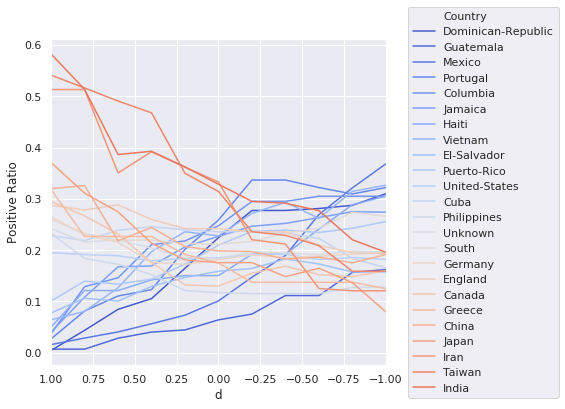

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(6,6)})

paAvgCountry = paAvg['native-country'].rename(columns={'native-country': 'Country'})

sns.set_palette(sns.color_palette("coolwarm", 28))

sns.lineplot(x='d', y='pr', hue='Country',
             hue_order = leg_order,
             data=paAvgCountry)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),)
plt.xlim(1, -1)
plt.ylabel('Positive Ratio')
plt.savefig('../Graphics/corrCountry.pdf', bbox_inches='tight')
plt.show()

In [206]:
auxdf = paAvg['race'][paAvg['race']['d'] == 1]
leg_order = auxdf.sort_values(by='pr')['race'].tolist()

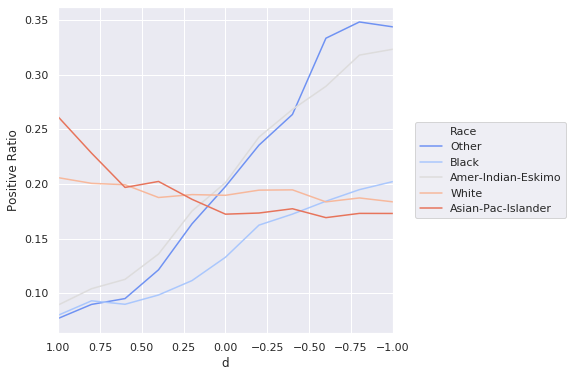

In [207]:
paAvgRace = paAvg['race'].rename(columns={'race': 'Race'})

sns.set_palette(sns.color_palette("coolwarm", 5))

sns.lineplot(x='d', y='pr', hue='Race',
             hue_order = leg_order,
             data=paAvgRace)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),)
plt.xlim(1, -1)
plt.ylabel('Positive Ratio')
plt.savefig('../Graphics/corrRace.pdf', bbox_inches='tight')
plt.show()

In [203]:
auxdf = paAvg['gender'][paAvg['gender']['d'] == 1]
leg_order = auxdf.sort_values(by='pr')['gender'].tolist()

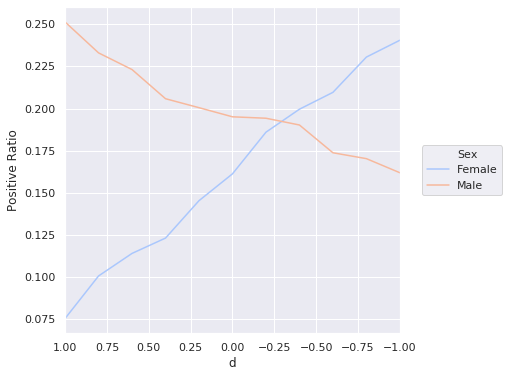

In [205]:
paAvgSex = paAvg['gender'].rename(columns={'gender': 'Sex'})

sns.set_palette(sns.color_palette("coolwarm", 2))
sns.lineplot(x='d', y='pr', hue='Sex', 
             hue_order=leg_order,
             data=paAvgSex)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),)
plt.xlim(1, -1)
plt.ylabel('Positive Ratio')
plt.savefig('../Graphics/corrGender.pdf', bbox_inches='tight')
plt.show()

In [200]:
auxdf = paAvg['decade'][paAvg['decade']['d'] == 1]
leg_order = auxdf.sort_values(by='pr')['decade'].tolist()

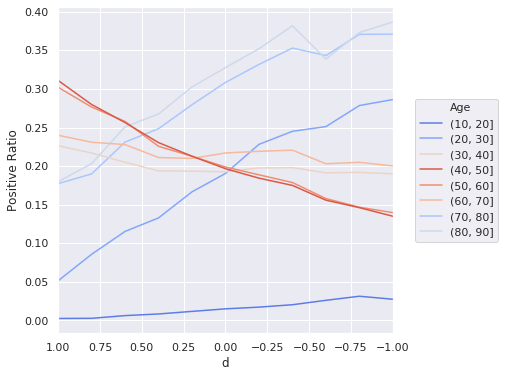

In [202]:
paAvgAge = paAvg['decade'].rename(columns={'decade': 'Age'})

sns.set_palette(sns.color_palette("coolwarm", 8))

sns.lineplot(x='d', y='pr', hue='Age',
             hue_order = leg_order,
             data=paAvgAge,)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,5,8,7,6,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='center left', bbox_to_anchor=(1.05, 0.5),)
plt.xlim(1, -1)
plt.ylabel('Positive Ratio')
plt.savefig('../Graphics/corrAge.pdf', bbox_inches='tight')
plt.show()

In [17]:
Xs = []
ys = []
for i in range(20):
    Xs.append([])
    ys.append([])
    for j in range(11):
#         Xs[i].append(experiments['expPSP']['Trains'][i][j].drop(['label', 'PA', 'over35'], axis=1).values)
        Xs[i].append(experiments['expPSP']['Trains'][i][j].drop(['label',], axis=1).values)
        ys[i].append(experiments['expPSP']['Trains'][i][j]['label'].values)

In [18]:
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

def makePredsCLF(Xs, ys, X_test, c):
    
    clfs = {'LR': partial(LogisticRegression, solver='liblinear'),
            'KNN': KNeighborsClassifier,
            'DT': DecisionTreeClassifier,
            'NB': GaussianNB,
           }

    models = []
    preds = []

    for i in range(11):
        model = clfs[c]()
        model.fit(Xs[i], ys[i])
        models.append(model)
    
        p = model.predict(X_test)
        preds.append(p)
    
    outputs = {
        'models': models,
        'preds': preds,
    }
    
    return outputs

In [19]:
def addPreds(test, preds):
    for i in range(11):
        test['pred' + str(i)] = preds[i]
    return test

In [24]:
def ClassifierCheck(Xs, ys, c):
    Tests = []
    toDrop = ['pred0', 'pred1', 'pred2', 'pred3', 'pred4',
              'pred5', 'pred6', 'pred7', 'pred8', 'pred9', 'pred10',
#               'over35', 'race', 'native-country', 'gender', 'decade',
             ]
    
    for i in range(5):
           
        test = experiments['expPSP']['Tests'][i].drop(toDrop, axis=1)
        X_test = experiments['expPSP']['Tests'][i].drop(['label',
#                                                          'PA',
                                                        ] + toDrop, axis=1).values
        outputs = makePredsCLF(Xs[i], ys[i], X_test, c)
        preds = outputs['preds']
        
        test = addPreds(test, preds)
        
        Tests.append(test)
    
    return Tests

In [25]:
lrPreds = ClassifierCheck(Xs, ys, 'LR')

In [26]:
dtPreds = ClassifierCheck(Xs, ys, 'DT')

In [27]:
nbPreds = ClassifierCheck(Xs, ys, 'NB')

In [28]:
clfPreds = {'lr': lrPreds, 'dt': dtPreds, 'nb': nbPreds,}
fav = 1

def getMetricsCLF(c='lr', pa='PA'):    
    from sklearn.metrics import accuracy_score
    
    Tests = clfPreds[c]
    Metrics = []

    for i in range(len(Tests)):
        test = Tests[i]
        dvals = [round((1 - 0.2 * i), 1) for i in range(11)]
        accs = [accuracy_score(test.label, test['pred' + str(i)]) for i in range(11)]
        f_accs = [accuracy_score(test[test[pa] == 0].label, test[test[pa] == 0]['pred' + str(i)]) for i in range(11)]
        m_accs = [accuracy_score(test[test[pa] == 1].label, test[test[pa] == 1]['pred' + str(i)]) for i in range(11)]
        unfav_pos = [test[test[pa] != fav]['pred' + str(i)].value_counts(normalize=True)[1]
                     for i in range(11)]
        fav_pos = [test[test[pa] == fav]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        tot_pos = [test['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        fem_pos = [test[test['sex'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        male_pos = [test[test['sex'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        w_pos = [test[test['White'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        nw_pos = [test[test['White'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        us_pos = [test[test['United-States'] == 1]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        nus_pos = [test[test['United-States'] == 0]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        o35_pos = [test[test['age'] >= 35]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]
        no35_pos = [test[test['age'] < 35]['pred' + str(i)].value_counts(normalize=True)[1]
                   for i in range(11)]

        metrics = pd.DataFrame({
            'disparity': dvals,
            'accuracy': accs,
            'fem_accu': f_accs,
            'male_accu': m_accs,
            'positive_rate': tot_pos,
            'unfav_positive_rate': unfav_pos,
            'fav_positive_rate': fav_pos,
            'fem_pos' : fem_pos,
            'male_pos': male_pos,
            'w_pos': w_pos,
            'nw_pos': nw_pos,
            'us_pos': us_pos,
            'nus_pos': nus_pos,
            'o35_pos': o35_pos,
            'no35_pos': no35_pos,
        })

        # Equality of Opportunity Metrics
        metrics['uo'] = [len(test[(test[pa] != fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] != fav) & (test.label == 1)]) for i in range(11)]
        metrics['fo'] = [len(test[(test[pa] == fav) & (test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[(test[pa] == fav) & (test.label == 1)]) for i in range(11)]
        metrics['eo'] = [len(test[(test.label == 1) & (test['pred' + str(i)] == 1)]) /
                         len(test[test.label == 1]) for i in range(11)]
        metrics['eo_rate'] = metrics.uo / metrics.fo


        # Append df to list
        Metrics.append(metrics)

    metrics = pd.concat(Metrics).groupby(level=0).mean()
    
    return metrics

In [30]:
# lrMetrics = getMetricsCLF('lr', 'PA')
lrMetrics = getMetricsCLF('lr', 'sex')

In [31]:
# dtMetrics = getMetricsCLF('dt', 'PA')
dtMetrics = getMetricsCLF('dt', 'sex')

In [32]:
# nbMetrics = getMetricsCLF('nb', 'PA')
nbMetrics = getMetricsCLF('nb', 'sex')

In [33]:
lrMetrics['dpRatio'] = lrMetrics.unfav_positive_rate / lrMetrics.fav_positive_rate
dtMetrics['dpRatio'] = dtMetrics.unfav_positive_rate / dtMetrics.fav_positive_rate
nbMetrics['dpRatio'] = nbMetrics.unfav_positive_rate / nbMetrics.fav_positive_rate

In [34]:
list(nbMetrics.columns)

['disparity',
 'accuracy',
 'fem_accu',
 'male_accu',
 'positive_rate',
 'unfav_positive_rate',
 'fav_positive_rate',
 'fem_pos',
 'male_pos',
 'w_pos',
 'nw_pos',
 'us_pos',
 'nus_pos',
 'o35_pos',
 'no35_pos',
 'uo',
 'fo',
 'eo',
 'eo_rate',
 'dpRatio']

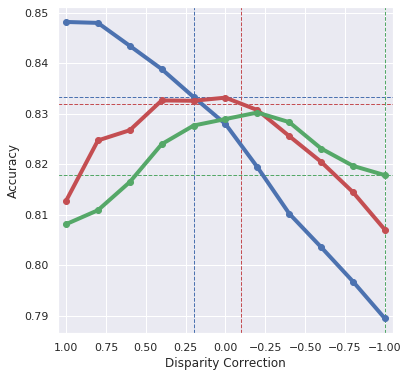

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(6,6)})

plt.axvline(x=0.2, color='b', linewidth=1, linestyle='--',)
plt.axhline(y=0.8333, color='b', linewidth=1, linestyle='--',)

plt.axvline(x=-0.1, color='r', linewidth=1, linestyle='--',)
plt.axhline(y=0.832, color='r', linewidth=1, linestyle='--',)

plt.axvline(x=-1, color='g', linewidth=1, linestyle='--',)
plt.axhline(y=0.818, color='g', linewidth=1, linestyle='--',)

plt.plot('disparity', 'accuracy', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'accuracy', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'accuracy', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1.05, -1.05)
# plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Accuracy')
plt.savefig('../Graphics/compareAcc.pdf', bbox_inches='tight')
plt.show()

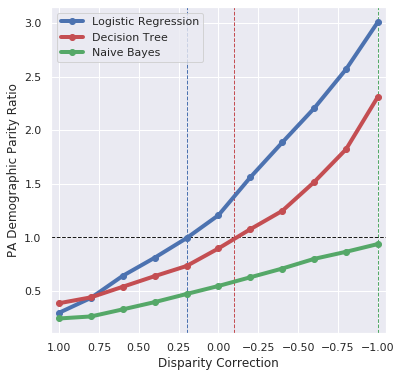

In [49]:
plt.axvline(x=0.2, color='b', linewidth=1, linestyle='--',)
plt.axvline(x=-0.1, color='r', linewidth=1, linestyle='--',)
plt.axvline(x=-1, color='g', linewidth=1, linestyle='--',)
plt.axhline(y=1, color='k', linewidth=1, linestyle='--',)

plt.plot('disparity', 'dpRatio', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'dpRatio', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'dpRatio', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')

plt.xlim(1.05, -1.05)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('PA Demographic Parity Ratio')
plt.savefig('../Graphics/compareDPR.pdf', bbox_inches='tight')
plt.show()

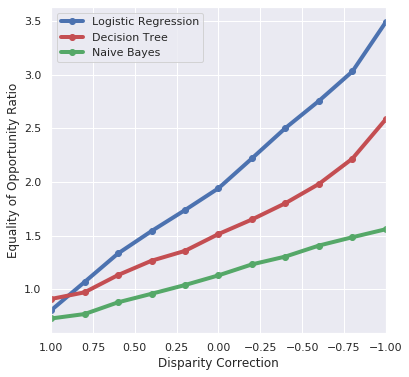

In [40]:
plt.plot('disparity', 'eo_rate', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'eo_rate', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'eo_rate', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1, -1)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Equality of Opportunity Ratio')
plt.savefig('../Graphics/compareEOR.pdf', bbox_inches='tight')
plt.show()

In [177]:
lrMetrics['dpRatioSex'] = lrMetrics.fem_pos / lrMetrics.male_pos
dtMetrics['dpRatioSex'] = dtMetrics.fem_pos / dtMetrics.male_pos
nbMetrics['dpRatioSex'] = nbMetrics.fem_pos / nbMetrics.male_pos

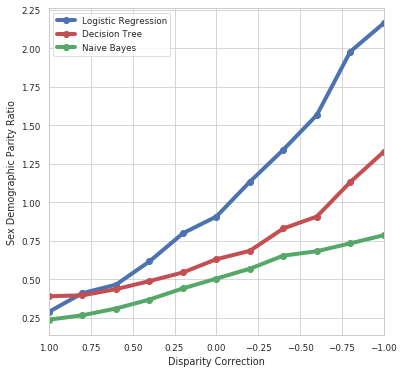

In [178]:
plt.plot('disparity', 'dpRatioSex', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'dpRatioSex', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'dpRatioSex', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1, -1)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Sex Demographic Parity Ratio')
plt.show()

In [179]:
lrMetrics['dpRatioRace'] = lrMetrics.nw_pos / lrMetrics.w_pos
dtMetrics['dpRatioRace'] = dtMetrics.nw_pos / dtMetrics.w_pos
nbMetrics['dpRatioRace'] = nbMetrics.nw_pos / nbMetrics.w_pos

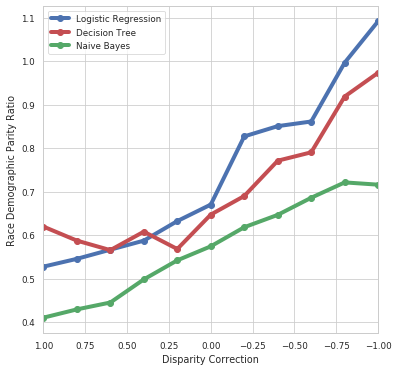

In [180]:
plt.plot('disparity', 'dpRatioRace', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'dpRatioRace', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'dpRatioRace', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1, -1)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Race Demographic Parity Ratio')
plt.show()

In [181]:
lrMetrics['dpRatioOrigin'] = lrMetrics.nus_pos / lrMetrics.us_pos
dtMetrics['dpRatioOrigin'] = dtMetrics.nus_pos / dtMetrics.us_pos
nbMetrics['dpRatioOrigin'] = nbMetrics.nus_pos / nbMetrics.us_pos

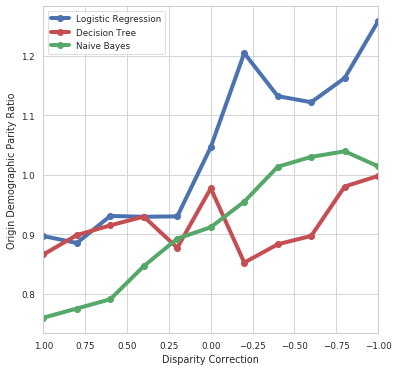

In [182]:
plt.plot('disparity', 'dpRatioOrigin', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'dpRatioOrigin', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'dpRatioOrigin', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1, -1)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Origin Demographic Parity Ratio')
plt.show()

In [183]:
lrMetrics['dpRatioAge'] = lrMetrics.no35_pos / lrMetrics.o35_pos
dtMetrics['dpRatioAge'] = dtMetrics.no35_pos / dtMetrics.o35_pos
nbMetrics['dpRatioAge'] = nbMetrics.no35_pos / nbMetrics.o35_pos

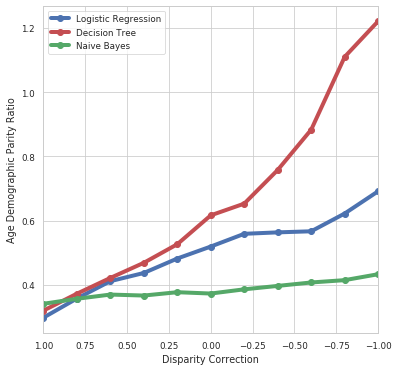

In [184]:
plt.plot('disparity', 'dpRatioAge', marker='o',
         markersize=6, linewidth=4, color='b', data=lrMetrics, label='Logistic Regression')
plt.plot('disparity', 'dpRatioAge', marker='o',
         markersize=6, linewidth=4, color='r', data=dtMetrics, label='Decision Tree')
plt.plot('disparity', 'dpRatioAge', marker='o',
         markersize=6, linewidth=4, color='g', data=nbMetrics, label='Naive Bayes')
plt.xlim(1, -1)
plt.legend()
plt.xlabel('Disparity Correction')
plt.ylabel('Age Demographic Parity Ratio')
plt.show()

# Metrics Plots

In [138]:
import pandas as pd
import numpy as np

Income = {
    'pa': 'sex',
    'label': 'label',
}

IncomePA = {
    'pa': 'PA',
    'label': 'label',
}

COMPAS = {
    'pa': 'race',
    'label': 'label',
}

German = {
    'pa': 'gender',
    'label': 'label',
}

DSets = {
    'Income': Income,
    'IncomePA': IncomePA,
    'COMPAS': COMPAS,
    'German': German,
}

In [139]:
# Set desired Dataset here
dset = 'IncomePA'

pa = DSets[dset]['pa']
label = DSets[dset]['label']

#### Load Files

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import findfont, FontProperties

sns.set_style('whitegrid')
colors = ['#e1485d', '#336184', '#3d998e', '#c6b839',] # '#8a5571'
paired = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
sns.set_palette(sns.color_palette(colors))
sns.set_context('paper')
font = findfont(FontProperties(family=['sans-serif']))

#url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'
url = '../Datasets/'
strats = ['fairCorrectUnder', 'fairCorrectOver', 'fairCorrectSMOTE', 'fairCorrectPSP']

Metrics = {s: pd.read_csv(url + 'mFairness_Metrics_' + dset + '_' + s + '.csv', header=0) for s in strats}
Coefs = {s: pd.read_csv(url + 'mFairness_Coefs_' + dset + '_' + s + '.csv', header=0) for s in strats}

show_all = strats[3]
sampstrat = show_all
metrics = Metrics[show_all]
metricsPS = Metrics['fairCorrectUnder']
dispPS = Coefs['fairCorrectUnder']

## Plots for Multi PA

#### Accuracy

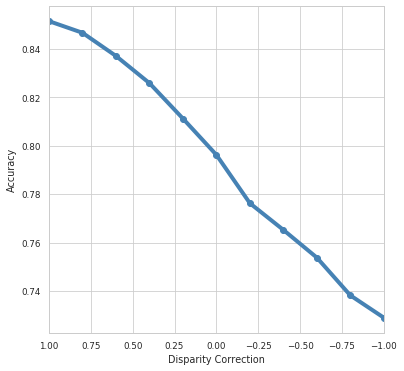

In [141]:
f = plt.figure()
plt.plot('disparity', 'accuracy', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics)
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Accuracy')
plt.show()

#### Combined PA

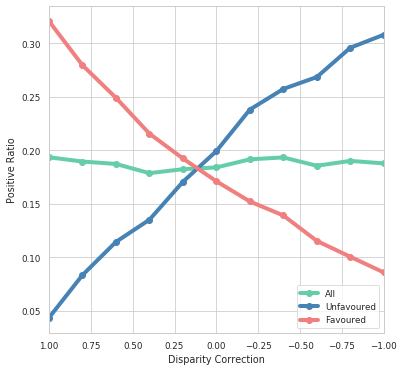

In [142]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'unfav_positive_rate', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Unfavoured')
plt.plot('disparity', 'fav_positive_rate', marker='o',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Favoured')
plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.show()

#### Sex

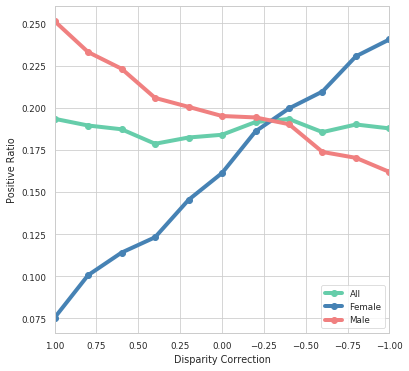

In [143]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'fem_pos', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Female')
plt.plot('disparity', 'male_pos', marker='o',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Male')
plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.show()

#### Race

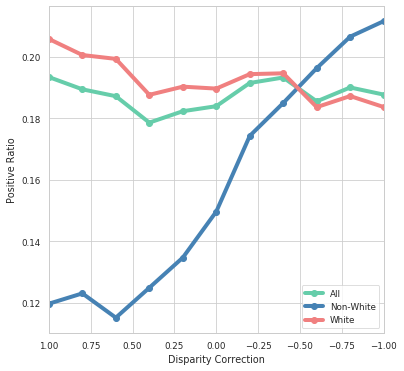

In [144]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'nw_pos', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Non-White')
plt.plot('disparity', 'w_pos', marker='o',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='White')
plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.show()

#### Origin

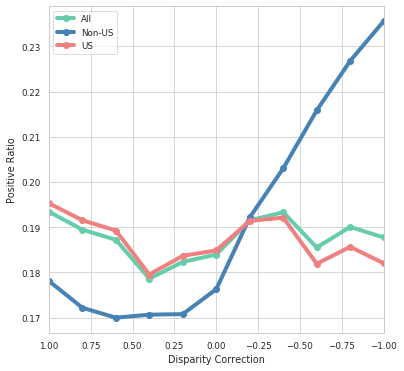

In [145]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'nus_pos', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Non-US')
plt.plot('disparity', 'us_pos', marker='o',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='US')
plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.show()

#### Age

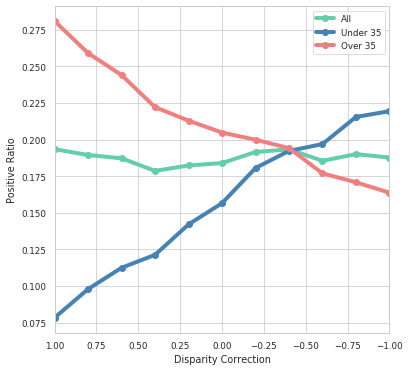

In [146]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='mediumaquamarine', data=metrics, label='All')
plt.plot('disparity', 'no35_pos', marker='o',
         markersize=6, linewidth=4, color='steelblue', data=metrics, label='Under 35')
plt.plot('disparity', 'o35_pos', marker='o',
         markersize=6, linewidth=4, color='lightcoral', data=metrics, label='Over 35')
plt.legend()
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.show()

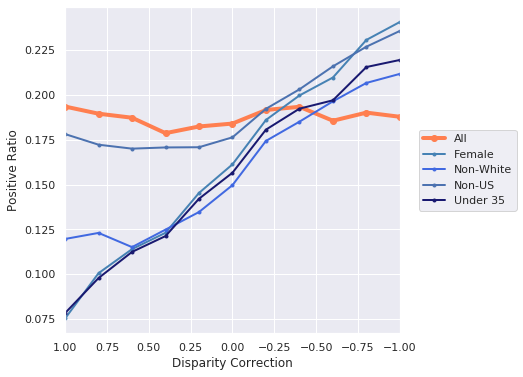

In [196]:
f = plt.figure()
plt.plot('disparity', 'positive_rate', marker='o',
         markersize=6, linewidth=4, color='coral', data=metrics, label='All')
plt.plot('disparity', 'fem_pos', marker='o',
         markersize=3, linewidth=2, color='steelblue', data=metrics, label='Female')
plt.plot('disparity', 'nw_pos', marker='o',
         markersize=3, linewidth=2, color='royalblue', data=metrics, label='Non-White')
plt.plot('disparity', 'nus_pos', marker='o',
         markersize=3, linewidth=2, color='b', data=metrics, label='Non-US')
plt.plot('disparity', 'no35_pos', marker='o',
         markersize=3, linewidth=2, color='midnightblue', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xlim(1, -1)
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Ratio')
plt.savefig('../Graphics/corrAll.pdf', bbox_inches='tight')
plt.show()

In [148]:
metrics.columns

Index(['disparity', 'accuracy', 'fem_accu', 'male_accu', 'positive_rate',
       'unfav_positive_rate', 'fav_positive_rate', 'fem_pos', 'male_pos',
       'w_pos', 'nw_pos', 'us_pos', 'nus_pos', 'o35_pos', 'no35_pos', 'uo',
       'fo', 'eo', 'eo_rate', 'r_accuracy', 'r_positive_rate',
       'r_unfav_positive_rate', 'r_fav_positive_rate', 'fav_pos_rate',
       'unfav_pos_rate', 'cfact', 'ucfact', 'fcfact', 'tcfact', 'favcf',
       'unfavcf', 'vola0', 'vola1', 'vola2', 'unfav_vola0', 'unfav_vola1',
       'unfav_vola2', 'fav_vola0', 'fav_vola1', 'fav_vola2', 'pSame',
       'pBetter', 'pWorse', 'uSame', 'uBetter', 'uWorse', 'fSame', 'fBetter',
       'fWorse'],
      dtype='object')

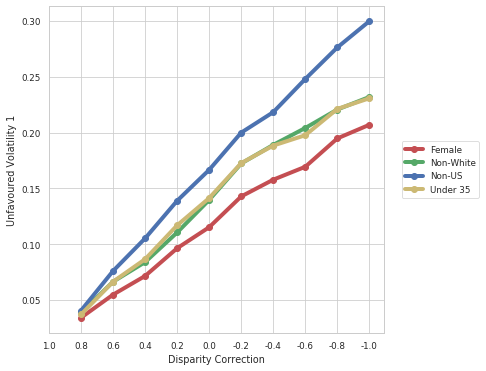

In [149]:
f = plt.figure()

plt.plot(volaDict['sex']['uvola'][1], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Female')
plt.plot(volaDict['race']['uvola'][1], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='Non-White')
plt.plot(volaDict['foreigner']['uvola'][1], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='Non-US')
plt.plot(volaDict['age']['uvola'][1], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Unfavoured Volatility 1')
plt.show()

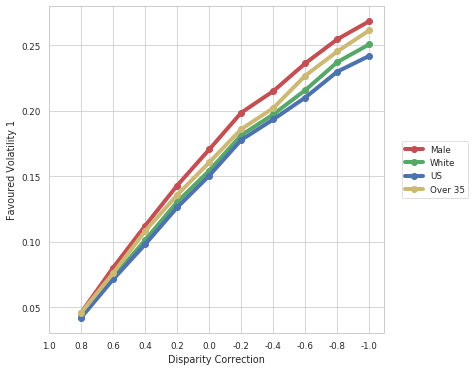

In [150]:
f = plt.figure()

plt.plot(volaDict['sex']['fvola'][1], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Male')
plt.plot(volaDict['race']['fvola'][1], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='White')
plt.plot(volaDict['foreigner']['fvola'][1], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='US')
plt.plot(volaDict['age']['fvola'][1], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Over 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Favoured Volatility 1')
plt.show()

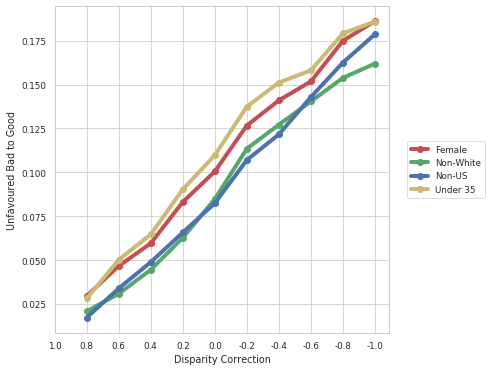

In [151]:
f = plt.figure()
plt.plot(volaDict['sex']['uchange'][1], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Female')
plt.plot(volaDict['race']['uchange'][1], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='Non-White')
plt.plot(volaDict['foreigner']['uchange'][1], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='Non-US')
plt.plot(volaDict['age']['uchange'][1], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Unfavoured Bad to Good')
plt.show()

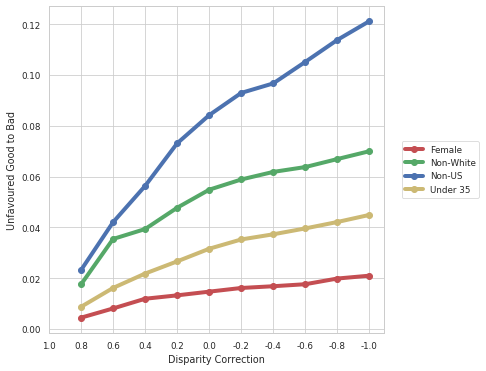

In [152]:
f = plt.figure()
plt.plot(volaDict['sex']['uchange'][2], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Female')
plt.plot(volaDict['race']['uchange'][2], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='Non-White')
plt.plot(volaDict['foreigner']['uchange'][2], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='Non-US')
plt.plot(volaDict['age']['uchange'][2], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Unfavoured Good to Bad')
plt.show()

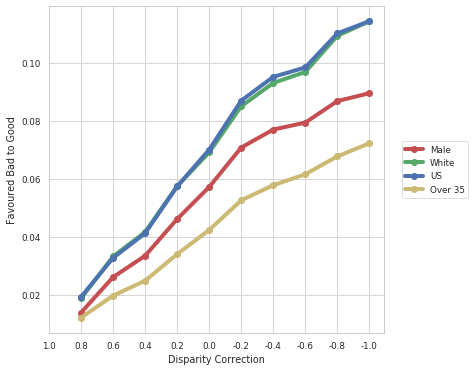

In [153]:
f = plt.figure()
plt.plot(volaDict['sex']['fchange'][1], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Male')
plt.plot(volaDict['race']['fchange'][1], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='White')
plt.plot(volaDict['foreigner']['fchange'][1], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='US')
plt.plot(volaDict['age']['fchange'][1], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Over 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Favoured Bad to Good')
plt.show()

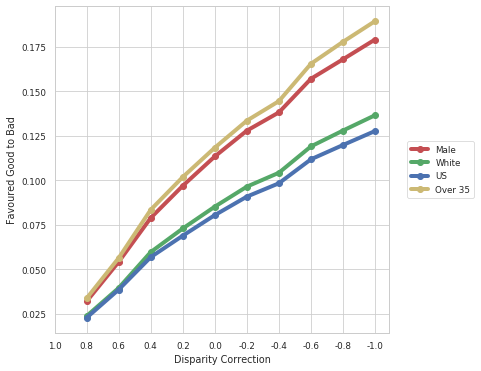

In [154]:
f = plt.figure()
plt.plot(volaDict['sex']['fchange'][2], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Male')
plt.plot(volaDict['race']['fchange'][2], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='White')
plt.plot(volaDict['foreigner']['fchange'][2], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='US')
plt.plot(volaDict['age']['fchange'][2], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Over 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Favoured Good to Bad')
plt.show()

### Positive Proportions in Train Subgroups

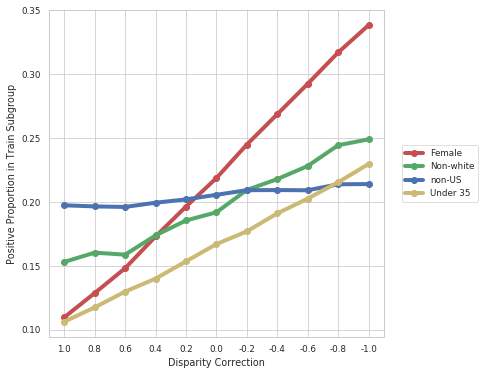

In [155]:
f = plt.figure()
plt.plot(propDict['sex'][0], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Female')
plt.plot(propDict['White'][0], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='Non-white')
plt.plot(propDict['United-States'][0], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='non-US')
plt.plot(propDict['over35'][0], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Proportion in Train Subgroup')
plt.show()

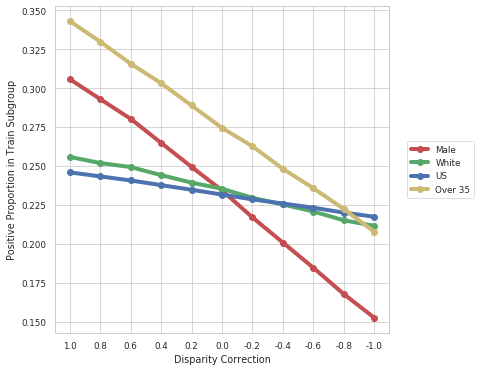

In [156]:
f = plt.figure()
plt.plot(propDict['sex'][1], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Male')
plt.plot(propDict['White'][1], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='White')
plt.plot(propDict['United-States'][1], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='US')
plt.plot(propDict['over35'][1], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Over 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Positive Proportion in Train Subgroup')
plt.show()

### Subgroup Proportion in Positive Train

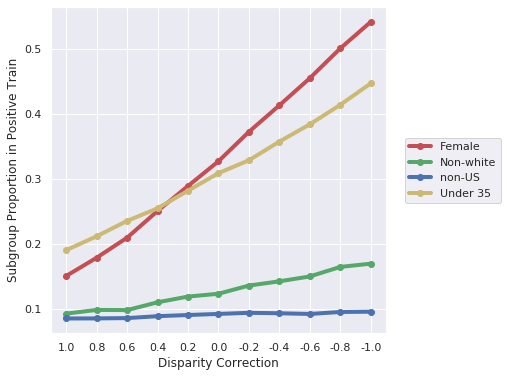

In [197]:
f = plt.figure()
plt.plot(propDicts['sex'][0], marker='o',
         markersize=6, linewidth=4, color='r', data=metrics, label='Female')
plt.plot(propDicts['White'][0], marker='o',
         markersize=6, linewidth=4, color='g', data=metrics, label='Non-white')
plt.plot(propDicts['United-States'][0], marker='o',
         markersize=6, linewidth=4, color='b', data=metrics, label='non-US')
plt.plot(propDicts['over35'][0], marker='o',
         markersize=6, linewidth=4, color='y', data=metrics, label='Under 35')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
plt.xticks(range(11), [round(1 - 0.2 * i, 1) for i in range(11)])
plt.xlabel('Disparity Correction')
plt.ylabel('Subgroup Proportion in Positive Train')
plt.savefig('../Graphics/propAll.pdf', bbox_inches='tight')
plt.show()

#### Next three blocks melt all metrics df's together for plots

In [4]:
mIncome = {s: pd.read_csv(url + '/mFairness_Metrics_' + 'Income' + '_' + s + '.csv', header=0) for s in strats}
mCOMPAS = {s: pd.read_csv(url + '/mFairness_Metrics_' + 'COMPAS' + '_' + s + '.csv', header=0) for s in strats}
mCredit = {s: pd.read_csv(url + '/mFairness_Metrics_' + 'German' + '_' + s + '.csv', header=0) for s in strats}

for s in strats:
    mIncome[s]['dset'] = 'Income'
    mIncome[s]['strat'] = s

    mCOMPAS[s]['dset'] = 'COMPAS'
    mCOMPAS[s]['strat'] = s

    mCredit[s]['dset'] = 'Credit'
    mCredit[s]['strat'] = s

In [5]:
cIncome = pd.concat([mIncome[s] for s in strats])
cCOMPAS = pd.concat([mCOMPAS[s] for s in strats])
cCredit = pd.concat([mCredit[s] for s in strats])

newStrats = ['Under', 'Over', 'SMOTE', 'PSP']
selCols = ['disparity', 'accuracy', 'statpar', 'tcfact', 'eo_rate', 'dset', 'strat',
           'vola0', 'vola1', 'vola2', 'unfav_vola0', 'unfav_vola1', 'unfav_vola2',
           'fav_vola0', 'fav_vola1', 'fav_vola2',
           'pSame', 'pBetter', 'pWorse', 'uSame', 'uBetter', 'uWorse',
           'fSame', 'fBetter', 'fWorse']
cAll = pd.concat([cIncome, cCOMPAS, cCredit])
cAll['strat'] = cAll['strat'].replace(strats, newStrats)
cAll['statpar'] = cAll.unfav_positive_rate / cAll.fav_positive_rate
cAlls = cAll[selCols]
cAlls.columns = ['d', 'accuracy', 'DPR', 'CFR', 'EOR', 'dset', 'strat',
                 'v0', 'v1', 'v2', 'uv0', 'uv1', 'uv2', 'fv0', 'fv1', 'fv2',
                 'pSame', 'pBetter', 'pWorse', 'uSame', 'uBetter', 'uWorse',
                 'fSame', 'fBetter', 'fWorse']

In [6]:
cAlls.head()

,d,accuracy,DPR,CFR,EOR,dset,strat,v0,v1,v2,...,fv2,pSame,pBetter,pWorse,uSame,uBetter,uWorse,fSame,fBetter,fWorse
0,1.0,0.850740,0.296721,0.681879,0.825951,Income,Under,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8,0.850261,0.354824,0.825326,0.925412,Income,Under,0.842057,0.016887,0.141056,...,0.177371,0.983113,0.008732,0.008155,0.985342,0.013747,0.000911,0.981993,0.006263,0.011744
2,0.6,0.848628,0.412309,0.944602,1.009857,Income,Under,0.839048,0.021271,0.139681,...,0.177092,0.978729,0.010998,0.010273,0.974985,0.024904,0.000110,0.980580,0.004119,0.015300
3,0.4,0.847492,0.470259,1.066138,1.089261,Income,Under,0.834830,0.028572,0.136598,...,0.174161,0.971428,0.013215,0.015358,0.965285,0.034640,0.000075,0.974511,0.002558,0.022931
4,0.2,0.846153,0.533909,1.267690,1.184126,Income,Under,0.829843,0.037206,0.132951,...,0.170243,0.962794,0.014768,0.022438,0.957115,0.042866,0.000019,0.965645,0.000799,0.033557


In [7]:
allMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat'], value_vars=['accuracy', 'DPR', 'CFR', 'EOR'],
                 var_name='metric', value_name='value')

fairMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'accuracy'], value_vars=['DPR', 'CFR', 'EOR'],
                 var_name='metric', value_name='value')

#### Make melt with volatilities

In [8]:
volaMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                   'accuracy'], value_vars=['v0', 'v1', 'v2'],
                   var_name='vola', value_name='v_value')
uvolaMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                    'accuracy'], value_vars=['uv0', 'uv1', 'uv2'],
                   var_name='vola', value_name='v_value')
fvolaMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                    'accuracy'], value_vars=['fv0', 'fv1', 'fv2'],
                   var_name='vola', value_name='v_value')

changeMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                    'accuracy'], value_vars=['pSame', 'pBetter', 'pWorse'],
                   var_name='change', value_name='ch_value')
uchangeMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                    'accuracy'], value_vars=['uSame', 'uBetter', 'uWorse'],
                   var_name='change', value_name='ch_value')
fchangeMelt = pd.melt(cAlls, id_vars=['d', 'dset', 'strat', 'DPR', 'EOR', 'CFR',
                                    'accuracy'], value_vars=['fSame', 'fBetter', 'fWorse'],
                   var_name='change', value_name='ch_value')

In [9]:
volaMelt['group'] = 'all'
uvolaMelt['group'] = 'unfavoured'
fvolaMelt['group'] = 'favoured'

volaMelt = volaMelt.replace({'vola': {'v0': 0, 'v1': 1, 'v2': 2}})
uvolaMelt = uvolaMelt.replace({'vola': {'uv0': 0, 'uv1': 1, 'uv2': 2}})
fvolaMelt = fvolaMelt.replace({'vola': {'fv0': 0, 'fv1': 1, 'fv2': 2}})

volaMeltFull = volaMelt.append(uvolaMelt)
volaMeltFull = volaMeltFull.append(fvolaMelt)
vmf = volaMeltFull.reset_index()
vmf.dropna(inplace=True)
vmf = vmf.drop(['index'], axis=1)

In [10]:
changeMelt['group'] = 'all'
uchangeMelt['group'] = 'unfavoured'
fchangeMelt['group'] = 'favoured'

changeMelt = changeMelt.replace({'change': {'pSame': 'same', 'pBetter': 'better', 'pWorse': 'worse'}})
uchangeMelt = uchangeMelt.replace({'change': {'uSame': 'same', 'uBetter': 'better', 'uWorse': 'worse'}})
fchangeMelt = fchangeMelt.replace({'change': {'fSame': 'same', 'fBetter': 'better', 'fWorse': 'worse'}})

changeMeltFull = changeMelt.append(uchangeMelt)
changeMeltFull = changeMeltFull.append(fchangeMelt)
cmf = changeMeltFull.reset_index()
cmf.dropna(inplace=True)
cmf = cmf.drop(['index'], axis=1)

#### Set group order

In [11]:
gOrd = ['unfavoured', 'all', 'favoured']
chOrd = ['worse', 'same', 'better']

### Better/Worse Plots

In [12]:
cmf.head()

,d,dset,strat,DPR,EOR,CFR,accuracy,change,ch_value,group
1,0.8,Income,Under,0.354824,0.925412,0.825326,0.850261,same,0.983113,all
2,0.6,Income,Under,0.412309,1.009857,0.944602,0.848628,same,0.978729,all
3,0.4,Income,Under,0.470259,1.089261,1.066138,0.847492,same,0.971428,all
4,0.2,Income,Under,0.533909,1.184126,1.267690,0.846153,same,0.962794,all
5,0.0,Income,Under,0.616765,1.299627,1.387432,0.844311,same,0.950771,all


#### By d-value

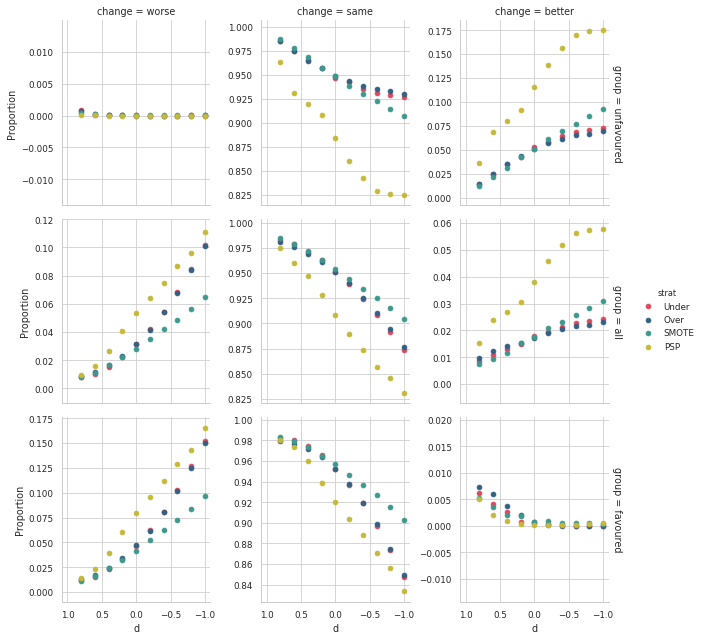

In [13]:
g = sns.FacetGrid(cmf[cmf.dset == 'Income'], col="change", row='group', hue="strat",
                  col_order=chOrd, row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'd', 'ch_value').add_legend()
g.set_ylabels('Proportion')

[g.axes[i][j].set_xlim([1.08,-1.08]) for i in range(3) for j in range(3)]

plt.show()

#### By DPR

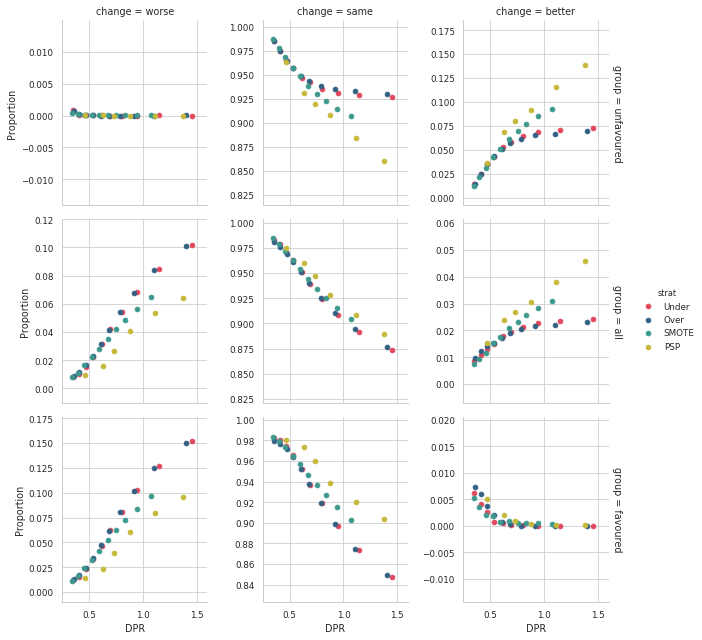

In [14]:
g = sns.FacetGrid(cmf[cmf.dset == 'Income'], col="change", row='group', hue="strat",
                  col_order=chOrd, row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'DPR', 'ch_value').add_legend()
g.set_ylabels('Proportion')

[g.axes[i][j].set_xlim([0.25,1.6]) for i in range(3) for j in range(3)]

plt.show()

#### By EOR

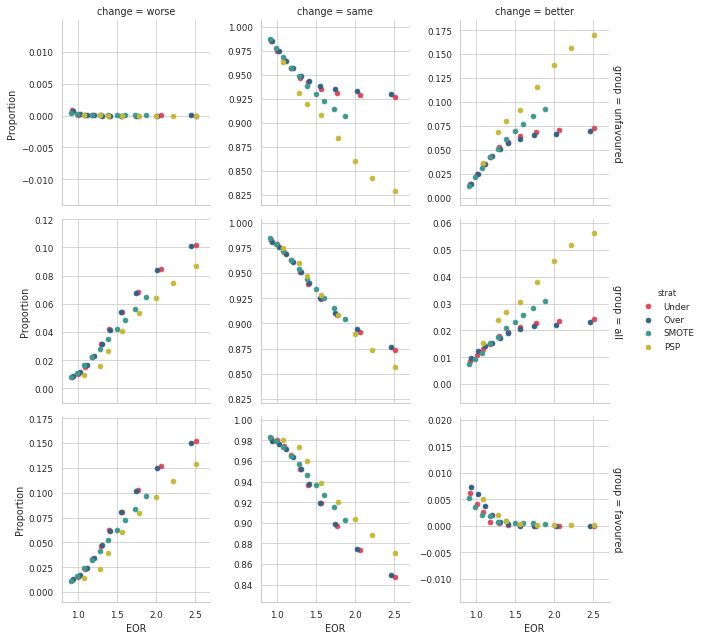

In [15]:
g = sns.FacetGrid(cmf[cmf.dset == 'Income'], col="change", row='group', hue="strat",
                  col_order=chOrd, row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'EOR', 'ch_value').add_legend()
g.set_ylabels('Proportion')

[g.axes[i][j].set_xlim([0.8,2.7]) for i in range(3) for j in range(3)]

plt.show()

#### By CFR

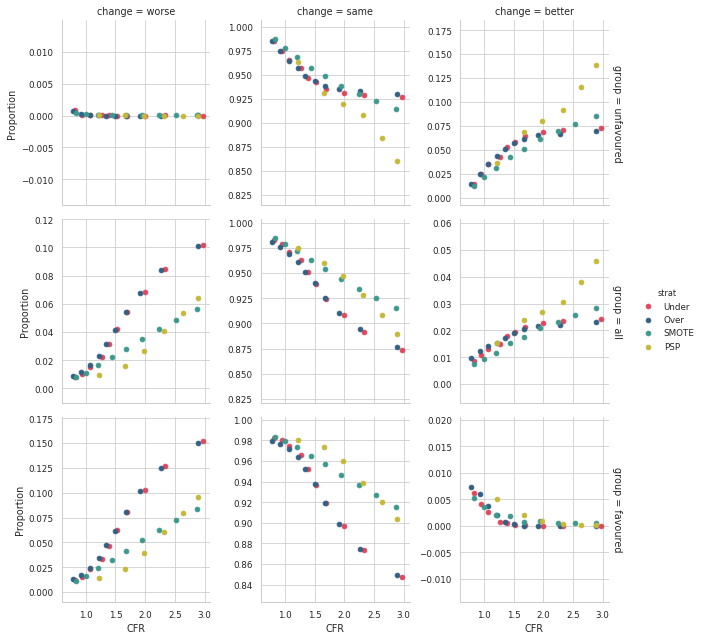

In [16]:
g = sns.FacetGrid(cmf[cmf.dset == 'Income'], col="change", row='group', hue="strat",
                  col_order=chOrd, row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'CFR', 'ch_value').add_legend()
g.set_ylabels('Proportion')

[g.axes[i][j].set_xlim([0.6,3.1]) for i in range(3) for j in range(3)]

plt.show()

### Volatility Plots

#### By d-value

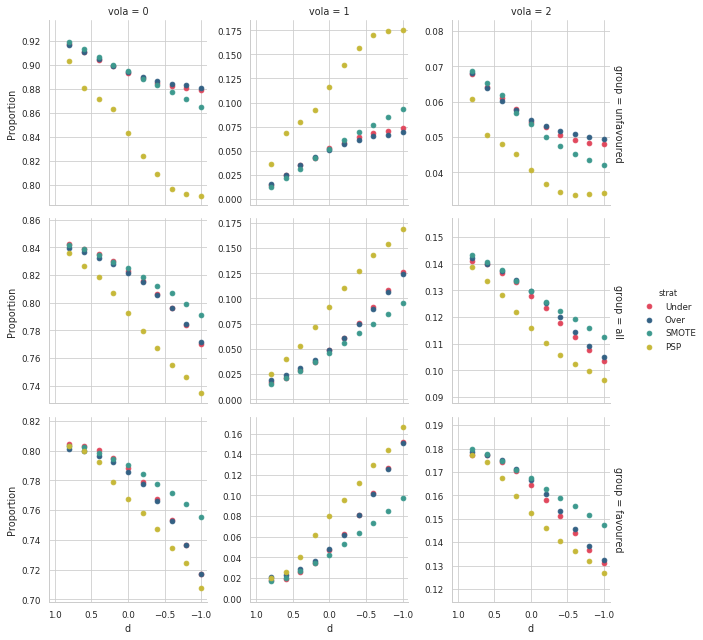

In [17]:
g = sns.FacetGrid(vmf[vmf.dset == 'Income'], col="vola", row='group', hue="strat",
                  row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'd', 'v_value').add_legend()
g.set_ylabels('Proportion')

[g.axes[i][j].set_xlim([1.08,-1.08]) for i in range(3) for j in range(3)]

plt.show()

#### By DPR

In [18]:
vmf.head()

,d,dset,strat,DPR,EOR,CFR,accuracy,vola,v_value,group
1,0.8,Income,Under,0.354824,0.925412,0.825326,0.850261,0,0.842057,all
2,0.6,Income,Under,0.412309,1.009857,0.944602,0.848628,0,0.839048,all
3,0.4,Income,Under,0.470259,1.089261,1.066138,0.847492,0,0.834830,all
4,0.2,Income,Under,0.533909,1.184126,1.267690,0.846153,0,0.829843,all
5,0.0,Income,Under,0.616765,1.299627,1.387432,0.844311,0,0.822911,all


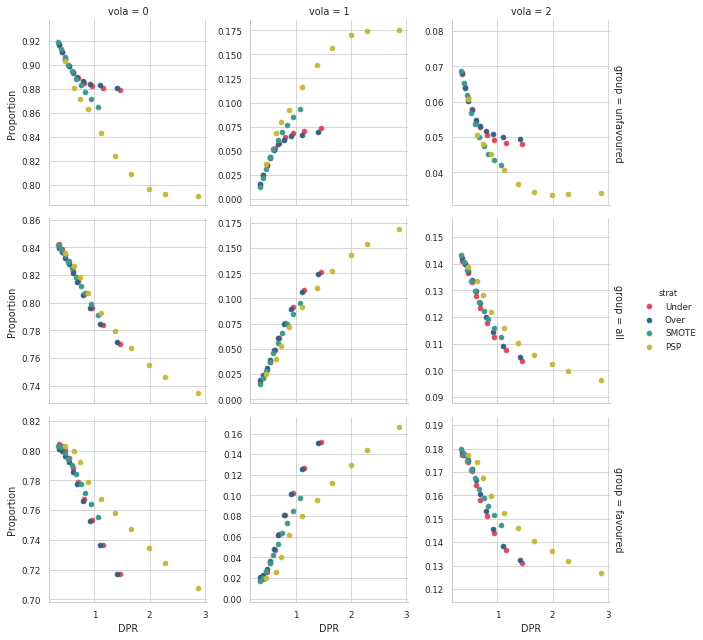

In [19]:
g = sns.FacetGrid(vmf[vmf.dset == 'Income'], col="vola", row='group', hue="strat",
                  row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'DPR', 'v_value').add_legend()
g.set_ylabels('Proportion')

plt.show()

#### By EOR

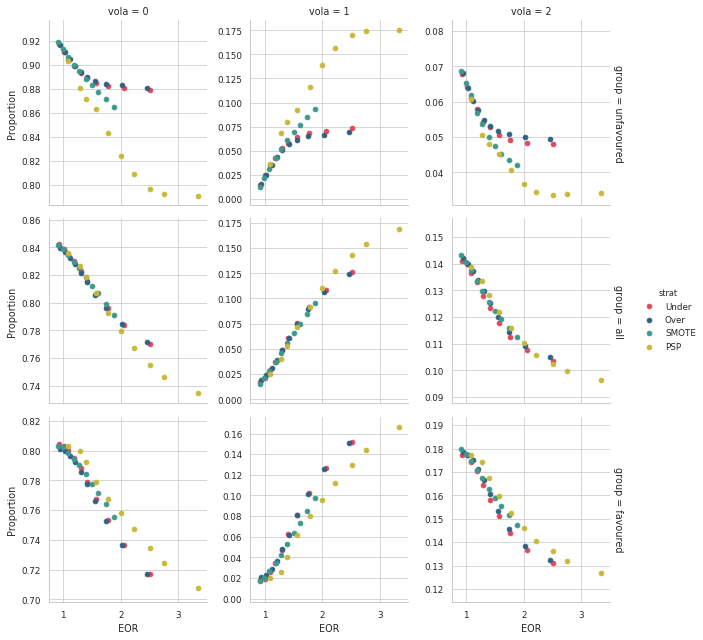

In [20]:
g = sns.FacetGrid(vmf[vmf.dset == 'Income'], col="vola", row='group', hue="strat",
                  row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'EOR', 'v_value').add_legend()
g.set_ylabels('Proportion')

plt.show()

#### By CFR

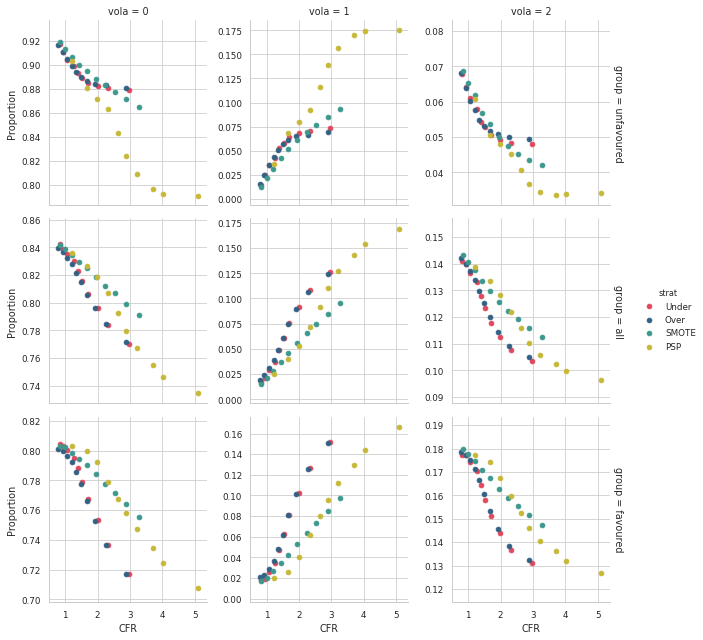

In [21]:
g = sns.FacetGrid(vmf[vmf.dset == 'Income'], col="vola", row='group', hue="strat",
                  row_order=gOrd, sharey=False, margin_titles=True)
g.map(plt.scatter, 'CFR', 'v_value').add_legend()
g.set_ylabels('Proportion')

plt.show()

### Plots for figures 4, 5, 6 and 7 generated here, savefiles commented

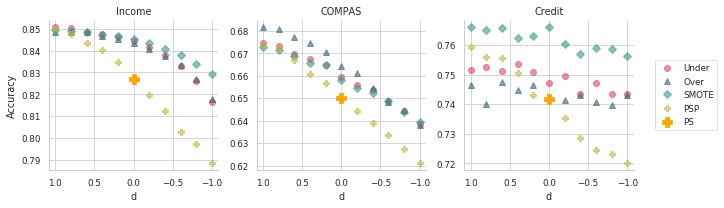

In [22]:
g = sns.FacetGrid(allMelt[allMelt.metric == 'accuracy'], col="dset", hue="strat",
                  sharey=False, hue_kws={'marker':['o', '^', 'D', 'P']})
g.map(plt.plot, 'd', 'value', ms=6, alpha=0.6, lw=0)
g.set_titles('{col_name}')
g.set_ylabels('Accuracy')

[g.axes[0][i].set_xlim([1.08,-1.08]) for i in range(3)]

psInc = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'Income')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCOMP = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'COMPAS')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]
      
psCred = allMelt[(allMelt.metric == 'accuracy')
        & (allMelt.dset == 'Credit')
        & (allMelt.strat == 'PSP')
        & (allMelt.d == 0)].value.iloc[0]

psAccs = [psInc, psCOMP, psCred]

[g.axes[0][i].scatter(0, psAccs[i], marker='P', s=100, label='PS', color='orange', zorder=3) for i in range(3)]

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.savefig('../Graphics/kAccs.pdf', bbox_inches='tight')
plt.show()

In [12]:
allMelt = allMelt.replace('PSP', 'PS')
allMelt.head()

,d,dset,strat,metric,value
0,1.0,Income,Under,accuracy,0.850740
1,0.8,Income,Under,accuracy,0.850261
2,0.6,Income,Under,accuracy,0.848628
3,0.4,Income,Under,accuracy,0.847492
4,0.2,Income,Under,accuracy,0.846153


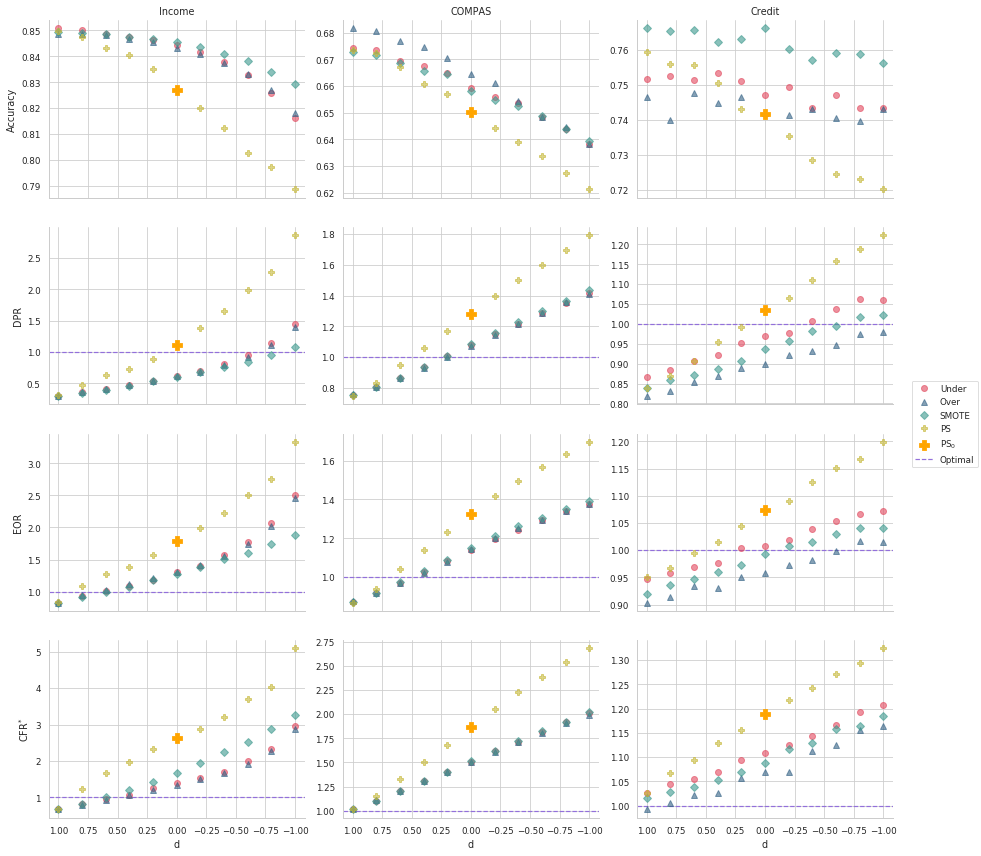

In [24]:
rowss = ['accuracy', 'DPR', 'EOR', 'CFR']
labelss = ['Accuracy', 'DPR', 'EOR', 'CFR$^{*}$']
titless = ['Income', 'COMPAS', 'Credit']

g = sns.FacetGrid(allMelt, col="dset", col_order=titless,
                  row='metric', row_order=rowss,
                  hue="strat", sharey=False, aspect=1.4,
                  hue_kws={'marker':['o', '^', 'D', 'P']})
g.map(plt.plot, 'd', 'value', ms=6, alpha=0.6, lw=0)
g.set_titles('')
#g.set_ylabels('')


[g.axes[i][0].set_ylabel(labelss[i]) for i in range(4)]
[g.axes[0][j].set_title(titless[j]) for j in range(3)]

for i in range(4):
    for j in range(3):
        g.axes[i][j].set_xlim([1.08,-1.08])
        
        ps = allMelt[(allMelt.metric == rowss[i])
                     & (allMelt.dset == titless[j])
                     & (allMelt.strat == 'PS')
                     & (allMelt.d == 0)].value.iloc[0]
        g.axes[i][j].scatter(0, ps, marker='P', s=100, label='PS$_{0}$', color='orange', zorder=3)

        if (i > 0):
            g.axes[i][j].axhline(1, ls='--', color='mediumpurple', zorder=1, label='Optimal')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,5,4]
g.fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../Graphics/allMetricsDsets.pdf', bbox_inches='tight')
plt.show()

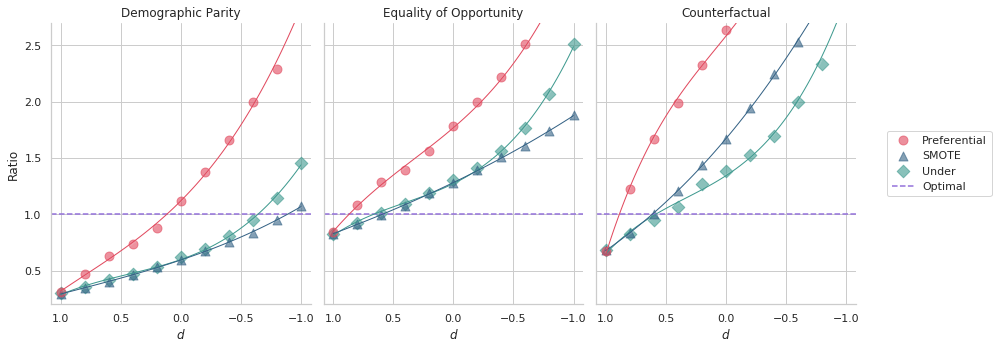

In [35]:
colors = ['#3d998e', '#336184', '#e1485d', '#c6b839',] # '#8a5571'
sns.set_palette(sns.color_palette(colors))
sns.set_context('notebook')

g = sns.lmplot(x="d", y="value", col="metric", col_order=['DPR', 'EOR', 'CFR'],
               hue='strat',
               data=fairMelt[(fairMelt.dset == 'Income') & (fairMelt.strat != 'Over')],
               sharex=False, sharey=True, order=3, ci=True, fit_reg=True, markers=['D', '^', 'o'],
               line_kws={'lw': 1,}, scatter_kws={'alpha': 0.6, 's': 80,},
               truncate=True, legend=False, aspect=0.8)

# g = sns.FacetGrid(fairMelt[(fairMelt.dset == 'Income') & (fairMelt.strat != 'Over')],
#                   col="metric", col_order=['DPR', 'EOR', 'CFR'], hue="strat",
#                   sharey=False, hue_kws={'marker':['D', '^', 'o']})
# g.map(plt.plot, 'd', 'value', ms=6, alpha=0.6, lw=1)

g.set_titles('Income')
g.set_ylabels('Ratio')
g.set_xlabels(r'$d$')

# Income
[g.axes[0][i].set_ylim([0.2,2.7]) for i in range(3)]

# COMPAS
# [g.axes[0][i].set_ylim([0.6,2.75]) for i in range(3)]

# Credit
# [g.axes[0][i].set_ylim([0.8,1.4]) for i in range(3)]

fsnames = ['Demographic Parity', 'Equality of Opportunity', 'Counterfactual']

# psInc = allMelt[(allMelt.metric == 'DPR')
#         & (allMelt.dset == 'Income')
#         & (allMelt.strat == 'PS')
#         & (allMelt.d == 0)].value.iloc[0]
      
# psCOMP = allMelt[(allMelt.metric == 'EOR')
#         & (allMelt.dset == 'Income')
#         & (allMelt.strat == 'PS')
#         & (allMelt.d == 0)].value.iloc[0]
      
# psCred = allMelt[(allMelt.metric == 'CFR')
#         & (allMelt.dset == 'Income')
#         & (allMelt.strat == 'PS')
#         & (allMelt.d == 0)].value.iloc[0]

# psAccs = [psInc, psCOMP, psCred]

for i in range(3):
#    g.axes[0][i].scatter(0, psAccs[i], marker='P', s=100, label='PS$_{0}$', color='orange', zorder=3)
    g.axes[0][i].axhline(1, ls='--', color='mediumpurple', zorder=1, label='Optimal')
    g.axes[0][i].set_xlim([1.08,-1.08])
    g.axes[0][i].set_title(fsnames[i])

handles, labels = plt.gca().get_legend_handles_labels()

# For lineplot
# llabs = ['Random Under', 'SMOTE', 'Preferential', 'Optimal']
# order = [2,1,0,3]

# For lmplot
llabs = ['Optimal', 'Under', 'SMOTE', 'Preferential']
order = [3,2,1,0]

plt.legend([handles[idx] for idx in order],[llabs[idx] for idx in order],
           loc='center left', bbox_to_anchor=(1.1, 0.5),)

#plt.subplots_adjust(wspace=0.3)
plt.savefig('../Graphics/Income_fair.pdf', bbox_inches='tight')
plt.show()

In [20]:
fairMelt = fairMelt.replace('PSP', 'PS')

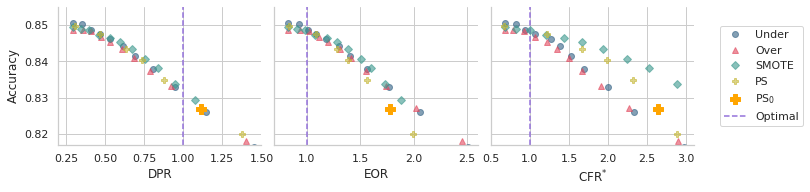

In [21]:
g = sns.FacetGrid(fairMelt[fairMelt.dset == 'Income'],
                  col="metric", col_order=['DPR', 'EOR', 'CFR'], hue="strat",
                  sharex=False, sharey=True, aspect=1.1,
                  hue_kws={'marker':['o', '^', 'D', 'P']})
g.map(plt.plot, 'value', 'accuracy', ms=6, alpha=0.6, lw=0)

g.set_titles('')

g.axes[0][0].set_xlabel('DPR')
g.axes[0][1].set_xlabel('EOR')
g.axes[0][2].set_xlabel('CFR$^{*}$')
    
g.axes[0][0].set_xlim([0.2,1.5])
g.axes[0][1].set_xlim([0.7,2.6])
g.axes[0][2].set_xlim([0.5,3.1])

g.axes[0][0].set_ylim([0.817, 0.855])

g.axes[0][0].set_yticks([0.82, 0.83, 0.84, 0.85])

g.set_ylabels('Accuracy')

fdNames = ['DPR', 'EOR', 'CFR']
psxs = [fairMelt[(fairMelt.d == 0) 
                 & (fairMelt.strat == 'PS') 
                 & (fairMelt.dset == 'Income')
                 & (fairMelt.metric == fd)].value for fd in fdNames]
psys = [fairMelt[(fairMelt.d == 0)
                 & (fairMelt.strat == 'PS')
                 & (fairMelt.dset == 'Income')
                 & (fairMelt.metric == fd)].accuracy for fd in fdNames]

for i in range(3):
    g.axes[0][i].scatter(psxs[i], psys[i], marker='P', s=100, label='PS$_{0}$', color='orange', zorder=3)
    g.axes[0][i].axvline(1, ls='--', label='Optimal', color='mediumpurple', zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,5,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('../Graphics/Income_FairvsAccuracy.pdf', bbox_inches='tight')
plt.show()

In [22]:
fairMelt.strat.value_counts()

Over     99
Under    99
SMOTE    99
PS       99
Name: strat, dtype: int64

In [23]:
fairMelt[fairMelt.strat == 'Under'].head()

,d,dset,strat,accuracy,metric,value
0,1.0,Income,Under,0.850740,DPR,0.296721
1,0.8,Income,Under,0.850261,DPR,0.354824
2,0.6,Income,Under,0.848628,DPR,0.412309
3,0.4,Income,Under,0.847492,DPR,0.470259
4,0.2,Income,Under,0.846153,DPR,0.533909


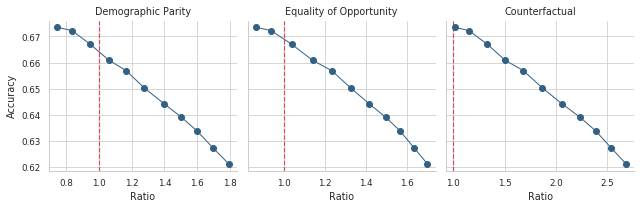

In [62]:
colors = ['#336184', '#e1485d', '#3d998e', '#c6b839',] # '#8a5571'
sns.set_palette(sns.color_palette(colors))
sns.set_context('paper')

g = sns.FacetGrid(fairMelt[(fairMelt.dset == 'COMPAS') & (fairMelt.strat == 'PS')],
                  col="metric", col_order=['DPR', 'EOR', 'CFR'],
                  sharex=False, sharey=True,
                  hue_kws={'marker':'o'})
g.map(plt.plot, 'value', 'accuracy', ms=6, lw=1)

# g.set_titles('')
g.set_xlabels('Ratio')

g.axes[0][0].set_title('Demographic Parity')
g.axes[0][1].set_title('Equality of Opportunity')
g.axes[0][2].set_title('Counterfactual')

g.set_ylabels('Accuracy')


for i in range(3):
    g.axes[0][i].axvline(1, ls='--', label='Optimal', color=colors[1], zorder=1)

plt.savefig('../Graphics/ID_Accu.pdf', bbox_inches='tight')
plt.show()

/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/vladox/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poor

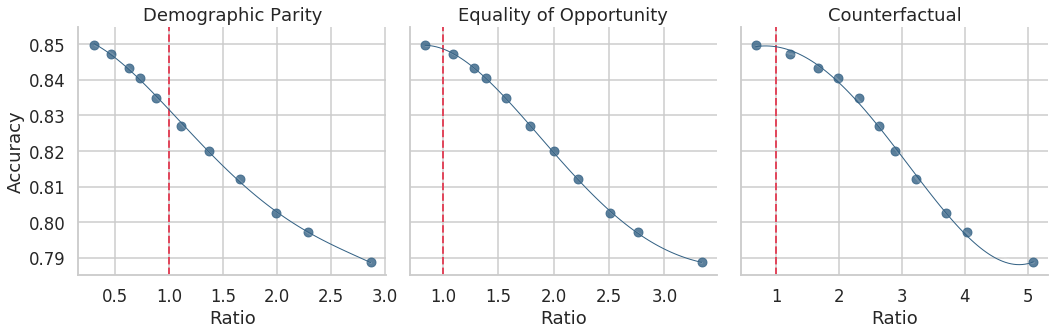

In [66]:
colors = ['#336184', '#e1485d', '#3d998e', '#c6b839',] # '#8a5571'
sns.set_palette(sns.color_palette(colors))
sns.set_context('talk')

g = sns.lmplot(x="value", y="accuracy", col="metric", col_order=['DPR', 'EOR', 'CFR'],
               data=fairMelt[(fairMelt.dset == 'Income') & (fairMelt.strat == 'PS')],
               sharex=False, sharey=True, order=4, ci=False,
               line_kws={'lw': 1,}, scatter_kws={'s': 80,}, truncate=True)

g.set_xlabels('Ratio')

g.axes[0][0].set_title('Demographic Parity')
g.axes[0][1].set_title('Equality of Opportunity')
g.axes[0][2].set_title('Counterfactual')

g.set_ylabels('Accuracy')
plt.ylim([0.785,0.855])

for i in range(3):
    g.axes[0][i].axvline(1, ls='--', lw=2, label='Optimal', color=colors[1], zorder=1)
    
plt.savefig('../Graphics/ID_Accu.pdf', bbox_inches='tight')
plt.show()

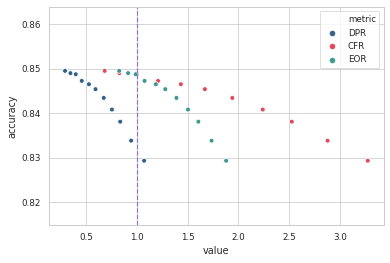

In [153]:
g = sns.scatterplot(x="value", y="accuracy", col='metric',
                    col_order=['DPR', 'EOR', 'CFR'],
                    data=fairMelt[(fairMelt.dset == 'Income')
                                  & (fairMelt.strat == 'SMOTE')])
g.axvline(1, ls='--', label='Optimal', color='mediumpurple', zorder=1)

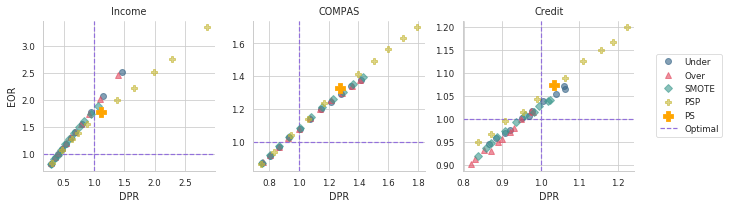

In [154]:
g = sns.FacetGrid(cAlls, col='dset', hue='strat',
                  sharex=False, sharey=False,
                  hue_kws={'marker':['o', '^', 'D', 'P']})
g.map(plt.plot, 'DPR', 'EOR', ms=6, alpha=0.6, lw=0)

g.set_titles('{col_name}')

dsNames = ['Income', 'COMPAS', 'Credit']
psxs = [cAlls[(cAlls.d == 0) & (cAlls.strat == 'PSP') & (cAlls.dset == ds)].DPR for ds in dsNames]
psys = [cAlls[(cAlls.d == 0) & (cAlls.strat == 'PSP') & (cAlls.dset == ds)].EOR for ds in dsNames]

for i in range(3):
    g.axes[0][i].scatter(psxs[i], psys[i], marker='P', s=100, label='PS', color='orange', zorder=3)
    g.axes[0][i].axvline(1, ls='--', label='Optimal', color='mediumpurple', zorder=1)
    g.axes[0][i].axhline(1, ls='--', color='mediumpurple', zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,5,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.savefig('../Graphics/DPRvsEOR.pdf', bbox_inches='tight')
plt.show()

#### Figure 3 plot

In [32]:
met2 = pd.melt(metrics, id_vars=['disparity'],
               value_vars=['fav_positive_rate', 'unfav_positive_rate', 'positive_rate'],
               var_name='pop', value_name='pr')

met2 = met2.replace('fav_positive_rate', 'Favoured')
met2 = met2.replace('unfav_positive_rate', 'Unfavoured')
met2 = met2.replace('positive_rate', 'Population')

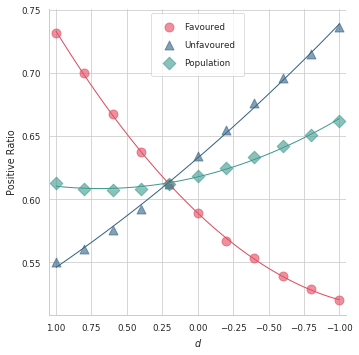

In [52]:
colors = ['#e1485d', '#336184', '#3d998e', '#c6b839',] # '#8a5571'
sns.set_palette(sns.color_palette(colors))
sns.set_context('paper')

g = sns.lmplot(x="disparity", y="pr", hue="pop", truncate=True,
           data=met2, markers=["o", "^", "D"],
           ci=False, fit_reg=True, order=2,
           legend=False, line_kws={'lw': 1,}, scatter_kws={'alpha':0.6, 's':80})

plt.xlim([1.05,-1.05])
plt.xlabel(r'$d$')
plt.ylabel('Positive Ratio')
plt.legend(labelspacing=1,borderpad=1)
plt.savefig("../Graphics/fcPositives_" + dset + '_' + sampstrat + ".pdf", bbox_inches='tight')

### Need to run the next blocks three times, once per pair: (Income, sex), (COMPAS, race) and (German, gender) as dset and pa. Otherwise, use the pregenerated Melt files

In [96]:
# dset = 'COMPAS'
# pa = 'race'

dset = 'Income'
pa = 'sex'

# dset = 'German'
# pa = 'gender'

In [97]:
dfUnder = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectUnder.csv', header=0)
dfOver = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectOver.csv', header=0)
dfSMOTE = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectSMOTE.csv', header=0)
dfPSP = pd.read_csv(url + 'Fairness_Coefs_' + dset + '_fairCorrectPSP.csv', header=0)

In [98]:
dfComp = dfUnder[['disparity']].copy()
dfComp['under'] = dfUnder[pa]
dfComp['over'] = dfOver[pa]
dfComp['smote'] = dfSMOTE[pa]
dfComp['psp'] = dfPSP[pa]

dfMelt = pd.melt(dfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='coef')
dfMelt['dset'] = dset

In [99]:
metricsUnder = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectUnder.csv', header=0)
metricsOver = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectOver.csv', header=0)
metricsSMOTE = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectSMOTE.csv', header=0)
metricsPSP = pd.read_csv(url + 'Fairness_Metrics_' + dset + '_fairCorrectPSP.csv', header=0)

In [100]:
metricsUnder['cfPar'] = metricsUnder['ucfact'] / metricsUnder['fcfact']
metricsOver['cfPar'] = metricsOver['ucfact'] / metricsOver['fcfact']
metricsSMOTE['cfPar'] = metricsSMOTE['ucfact'] / metricsSMOTE['fcfact']
metricsPSP['cfPar'] = metricsPSP['ucfact'] / metricsPSP['fcfact']

cfComp = metricsUnder[['disparity']].copy()
cfComp['under'] = metricsUnder['cfPar']
cfComp['over'] = metricsOver['cfPar']
cfComp['smote'] = metricsSMOTE['cfPar']
cfComp['psp'] = metricsPSP['cfPar']

cfMelt = pd.melt(cfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['cfRate'] = cfMelt['rate']

In [101]:
tcfComp = metricsUnder[['disparity']].copy()
tcfComp['under'] = metricsUnder['tcfact']
tcfComp['over'] = metricsOver['tcfact']
tcfComp['smote'] = metricsSMOTE['tcfact']
tcfComp['psp'] = metricsPSP['tcfact']

tcfMelt = pd.melt(tcfComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['tcfRate'] = tcfMelt['rate']

In [102]:
eoComp = metricsUnder[['disparity']].copy()
eoComp['under'] = metricsUnder['eo_rate']
eoComp['over'] = metricsOver['eo_rate']
eoComp['smote'] = metricsSMOTE['eo_rate']
eoComp['psp'] = metricsPSP['eo_rate']

eoMelt = pd.melt(eoComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['eoRate'] = eoMelt['rate']

In [103]:
metricsUnder['statPar'] = metricsUnder.unfav_positive_rate / metricsUnder.fav_positive_rate
metricsOver['statPar'] = metricsOver.unfav_positive_rate / metricsOver.fav_positive_rate
metricsSMOTE['statPar'] = metricsSMOTE.unfav_positive_rate / metricsSMOTE.fav_positive_rate
metricsPSP['statPar'] = metricsPSP.unfav_positive_rate / metricsPSP.fav_positive_rate

In [104]:
spComp = metricsUnder[['disparity']].copy()
spComp['under'] = metricsUnder['statPar']
spComp['over'] = metricsOver['statPar']
spComp['smote'] = metricsSMOTE['statPar']
spComp['psp'] = metricsPSP['statPar']

spMelt = pd.melt(spComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='rate')

dfMelt['spRate'] = spMelt['rate']

In [105]:
acComp = metricsUnder[['disparity']].copy()
acComp['under'] = metricsUnder['accuracy']
acComp['over'] = metricsOver['accuracy']
acComp['smote'] = metricsSMOTE['accuracy']
acComp['psp'] = metricsPSP['accuracy']

spMelt = pd.melt(acComp, id_vars=['disparity'], value_vars=['under', 'over', 'smote', 'psp'],
                 var_name='sampling', value_name='accuracy')

dfMelt['accuracy'] = spMelt['accuracy']

In [106]:
#dfMelt.to_csv('../Datasets/Melt' + dset + '.csv', index=False)

## Can continue here using pre-generated files

In [34]:
url = 'https://raw.githubusercontent.com/vladoxNCL/fairCorrect/master/Datasets/'

mInc = pd.read_csv(url + 'MeltIncome.csv', header=0)
mCOM = pd.read_csv(url + 'MeltCOMPAS.csv', header=0)
mGer = pd.read_csv(url + 'MeltGerman.csv', header=0)

frames = [mInc, mCOM, mGer]
melts = pd.concat(frames)

### Generate the plots for figure 8 in paper

In [35]:
melts = melts.replace('German', 'Credit')

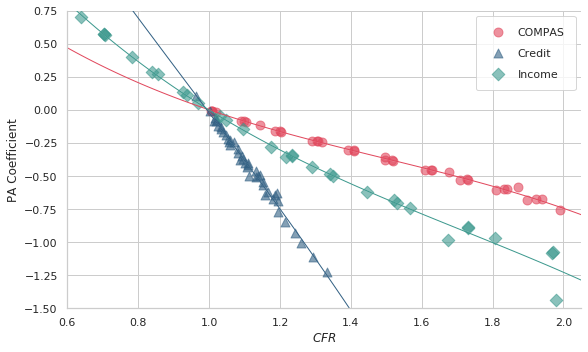

In [50]:
colors = ['#e1485d', '#336184', '#3d998e', '#c6b839',] # '#8a5571'
sns.set_palette(sns.color_palette(colors))
sns.set_context('notebook')

sns.lmplot(x="tcfRate", y="coef", hue="dset",
           data=melts[melts['tcfRate'] < 2],
           markers=["o", "^", "D"], ci=False, fit_reg=True,
           order=3, legend=False, hue_order=['COMPAS','Credit','Income'],
           line_kws={'lw': 1,}, scatter_kws={'alpha':0.6, 's':80}, aspect=1.618)
plt.xlim((0.6,2.05))
plt.ylim((-1.5,0.75))
plt.xlabel(r'$CFR$')
plt.ylabel('PA Coefficient')
plt.legend(labelspacing=1,borderpad=1)
plt.savefig("../Graphics/tcfCoefs.pdf", bbox_inches='tight')